In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import json
import time
import os
import re
import tensorflow as tf
import tensorflow_probability as tfp
import pickle
import string
import scipy.stats as st
import tensorflow as tf
import sys

# Need in order to call models from models.py in directory above
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn')
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn/models')

tfd = tfp.distributions

InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

/Users/milesturpin/miniconda3/envs/latent/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/milesturpin/miniconda3/envs/latent/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/milesturpin/miniconda3/envs/latent/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/milesturpin/minico

In [2]:
pd.set_option('precision', 4)
pd.options.display.max_colwidth = 200
#pd.options.display.column_space = 32
#pd.options.display.width = 1000

# Do this when running in terminal!
#pd.options.display.width = None

In [3]:
data_size = 'small'
x_train = np.load('../data/femnist/{data_size}/x_train.npy'.format(data_size=data_size))
y_train = np.load('../data/femnist/{data_size}/y_train.npy'.format(data_size=data_size))
gid_train = np.load('../data/femnist/{data_size}/gid_train.npy'.format(data_size=data_size))
x_test = np.load('../data/femnist/{data_size}/x_test.npy'.format(data_size=data_size))
y_test = np.load('../data/femnist/{data_size}/y_test.npy'.format(data_size=data_size))
gid_test = np.load('../data/femnist/{data_size}/gid_test.npy'.format(data_size=data_size))

In [4]:
writer_df = pd.DataFrame(np.stack([y_train, gid_train]).T, 
                         columns=['label', 'writer'])
distribution_of_labels = writer_df.groupby('writer')['label'].value_counts().unstack().fillna(0)
samples_per_writer = writer_df.groupby('writer').size().rename('num_train_samples')
samples_weights = samples_per_writer.transform(lambda x: x/x.sum())

## Review all experiments

In [23]:
import re 
results_df_list = []
hyperparams = []
mod_hyperparams = []

directories = !cd ../experiments/femnist; ls -d -- */

for exp_dir in directories:
    exp_path = os.path.join('..','experiments', 'femnist', exp_dir)
    
    # Merge training stats csv's
    training_stats_files = !cd {exp_path}; ls -d -- training_stats*
    df_list = []
    try:
        for file in training_stats_files:
            df_list.append(pd.read_csv(os.path.join(exp_path, file)))
        df = pd.concat(df_list)
        df = df.set_index(['epoch', 'gid'])
        results_df_list.append(df)
    except:
        pass
    
    # load hyperparam json file
    with open(os.path.join(exp_path, 'hyperparams.json'),'r') as f:
        hyper = json.load(f)
        hyperparams.append(hyper)
        mod_hyper = hyper.copy()
        # clean up date string
        mod_hyper['date'] = re.sub('_',' ', re.sub('/','', re.sub('2019-','',exp_dir)))
        # Need this so can groupby later
        mod_hyper['z_dim'] = str(mod_hyper['z_dim'])
        if mod_hyper['seed'] is None:
            mod_hyper['seed']=-1
        if mod_hyper['description'] is None:
            mod_hyper['description']=-1
        mod_hyperparams.append(mod_hyper)
    
config_df = pd.concat((pd.Series(param_dict) for param_dict in mod_hyperparams), axis=1).T

/Users/milesturpin/miniconda3/envs/latent/lib/python3.5/site-packages/ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [24]:
temp = config_df.drop(['seed', 'testing', 'print_freq', 'both', 'data_dir', 'variational', 'latent_space', 'eval_every'],1)
# Move description to end
display(temp[[col for col in temp if col not in ['description']] + ['description']].tail(15))

,batch_size,data_size,dataset,date,latent_config,lr,model_size,num_epochs,z_dim,description
43,200,small,femnist,08-11 16-25-00,none,0.004,small,5,"[10, 10]",trying this all over from scratch because the reading and writing model weights isn't working. not doing full epochs
44,200,small,femnist,08-11 21-46-21,double,0.004,small,10,"[16, 16]","actually using KL loss, properly weighted"
45,200,small,femnist,08-11 22-19-23,factor,0.004,small,10,[16],"actually using KL loss, properly weighted"
46,200,small,femnist,08-11 22-50-27,bias,0.004,small,10,[16],"actually using KL loss, properly weighted"
47,200,small,femnist,08-20 18-32-40,lower,0.004,small,10,[16],"actually using KL loss, properly weighted"
48,200,small,femnist,08-21 02-43-34,weight,0.004,small,10,[16],"lazy adam, log prob of factored weights, zdim=10"
49,200,small,femnist,08-21 02-52-46,weight,0.004,small,10,[16],"lazy adam, log prob, factored weights, factored biases"
50,200,small,femnist,08-21 21-17-21,weight,0.004,small,10,[16],"normal adam, log prob, factored weights, factored biases"
51,200,small,femnist,08-21 22-40-14,weight,0.004,small,10,[16],"normal adam, log prob, factored weights, factored biases, earlier layer too, oops forgot relu"
52,200,small,femnist,08-21 23-15-23,weight,0.004,small,10,[16],"normal adam, log prob, factored weights, factored biases, lr sched"


### Pick which experiments to visualize

In [25]:
directories = !cd ../experiments/femnist; ls -d -- */
directories = directories[-14:]

In [26]:
results_df_list = []
hyperparams = []
mod_hyperparams = []
for exp_dir in directories:
    exp_path = os.path.join('..','experiments', 'femnist', exp_dir)
    
    # Merge training stats csv's
    training_stats_files = !cd {exp_path}; ls -d -- training_stats*
    df_list = []
    try:
        for file in training_stats_files:
            df_list.append(pd.read_csv(os.path.join(exp_path, file)))
        df = pd.concat(df_list)
        df = df.set_index(['epoch', 'gid'])
        results_df_list.append(df)
    except:
        pass
    
    # load hyperparam json file
    with open(os.path.join(exp_path, 'hyperparams.json'),'r') as f:
        hyper = json.load(f)
        mod_hyper = hyper.copy()
        hyperparams.append(hyper)
        # Need this so can groupby later
        mod_hyper['z_dim'] = str(mod_hyper['z_dim'])
        # clean up date string
        mod_hyper['date'] = re.sub('_',' ', re.sub('/','', re.sub('2019-','',exp_dir)))
        
        if mod_hyper['seed'] is None:
            mod_hyper['seed']=-1
        if mod_hyper['description'] is None:
            mod_hyper['description']=-1
        try:
            blub = mod_hyper['latent_config']
        except:
            mod_hyper['latent_config']='NA'
        mod_hyperparams.append(mod_hyper)
    
config_df = pd.concat((pd.Series(param_dict) for param_dict in mod_hyperparams), axis=1).T


### Visualize results

,batch_size,data_size,dataset,date,latent_config,lr,model_size,num_epochs,z_dim,description
0,200,small,femnist,08-11 21-46-21,double,0.004,small,10,"[16, 16]","actually using KL loss, properly weighted"
1,200,small,femnist,08-11 22-19-23,factor,0.004,small,10,[16],"actually using KL loss, properly weighted"
2,200,small,femnist,08-11 22-50-27,bias,0.004,small,10,[16],"actually using KL loss, properly weighted"
3,200,small,femnist,08-20 18-32-40,lower,0.004,small,10,[16],"actually using KL loss, properly weighted"
4,200,small,femnist,08-21 02-43-34,weight,0.004,small,10,[16],"lazy adam, log prob of factored weights, zdim=10"
5,200,small,femnist,08-21 02-52-46,weight,0.004,small,10,[16],"lazy adam, log prob, factored weights, factored biases"
6,200,small,femnist,08-21 21-17-21,weight,0.004,small,10,[16],"normal adam, log prob, factored weights, factored biases"
7,200,small,femnist,08-21 22-40-14,weight,0.004,small,10,[16],"normal adam, log prob, factored weights, factored biases, earlier layer too, oops forgot relu"
8,200,small,femnist,08-21 23-15-23,weight,0.004,small,10,[16],"normal adam, log prob, factored weights, factored biases, lr sched"
9,200,small,femnist,08-21 23-30-56,weight,0.004,small,10,"[10, 16]","normal adam, log prob, factored weights, factored biases, lr sched"


Config 0: test accuracy = 0.862, 50th percentile = 0.875, 10th percentile = 0.722, 90th percentile = 1.0
Config 1: test accuracy = 0.851, 50th percentile = 0.868, 10th percentile = 0.706, 90th percentile = 1.0
Config 2: test accuracy = 0.811, 50th percentile = 0.816, 10th percentile = 0.642, 90th percentile = 0.944
Config 3: test accuracy = 0.854, 50th percentile = 0.875, 10th percentile = 0.706, 90th percentile = 0.974
Config 4: test accuracy = 0.843, 50th percentile = 0.857, 10th percentile = 0.688, 90th percentile = 1.0
Config 5: test accuracy = 0.839, 50th percentile = 0.857, 10th percentile = 0.677, 90th percentile = 1.0
Config 6: test accuracy = 0.846, 50th percentile = 0.857, 10th percentile = 0.696, 90th percentile = 1.0
Config 7: test accuracy = 0.816, 50th percentile = 0.833, 10th percentile = 0.665, 90th percentile = 0.944
Config 8: test accuracy = 0.855, 50th percentile = 0.873, 10th percentile = 0.714, 90th percentile = 0.973
Config 9: test accuracy = 0.867, 50th percentil

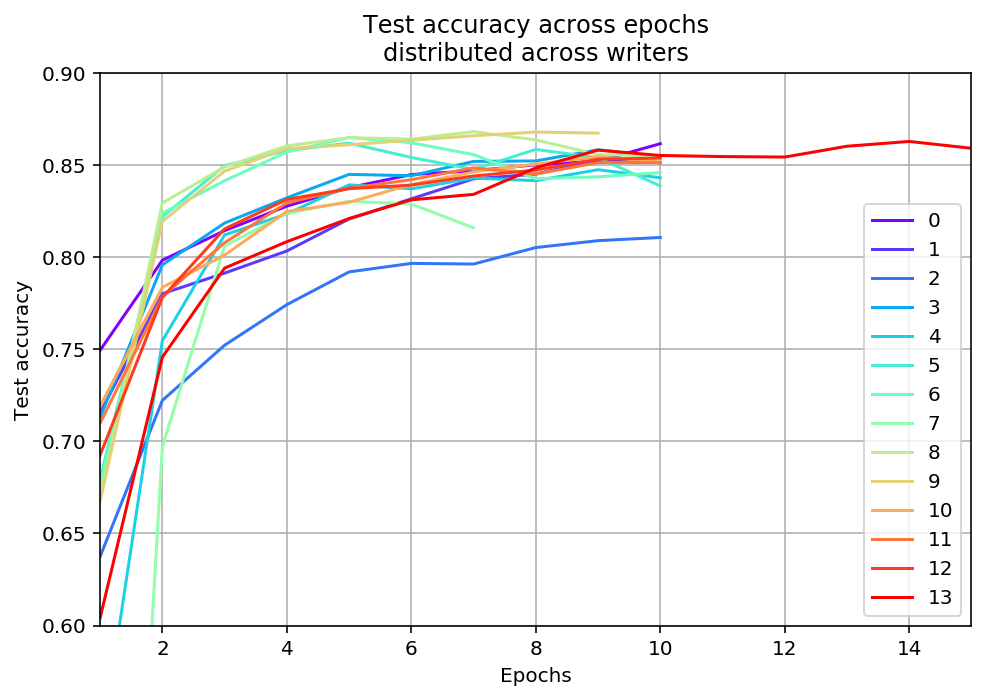

In [27]:
num_configs = len(directories)

temp = config_df.drop(['seed', 'testing', 'print_freq', 'eval_every', 'data_dir'],1)
# Move description to end
display(temp[[col for col in temp if col not in ['description']] + ['description']])

mean_accs = []
for i, train_stats in enumerate(results_df_list):
    fed_acc_df = train_stats['test_acc'].unstack()
    mean_acc = fed_acc_df.apply(lambda s: np.dot(s.values, samples_weights.values), axis=1)
    mean_accs.append(mean_acc)

    get_percentile = lambda perc: np.percentile(
        sorted(fed_acc_df.tail(1).squeeze().dropna().values), perc)
    stats = [
        round(np.dot(fed_acc_df.tail(1).squeeze().values, samples_weights.values),3),
        round(get_percentile(50),3),
        round(get_percentile(10),3),
        round(get_percentile(90),3)]
    print('Config {}: test accuracy = {}, 50th percentile = {}, 10th percentile = {}, 90th percentile = {}'.format(i, *stats))
    
ax = pd.concat(mean_accs, axis=1).plot(figsize=(7,5), cmap='rainbow')
#for i in range(4):
#    pd.concat(mean_accs, axis=1).reset_index().plot.scatter(x='epoch', y=i,figsize=(7,5), ax=ax)
plt.title('Test accuracy across epochs\ndistributed across writers')
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.grid(True)
plt.ylim([0.6,0.9])
plt.tight_layout();

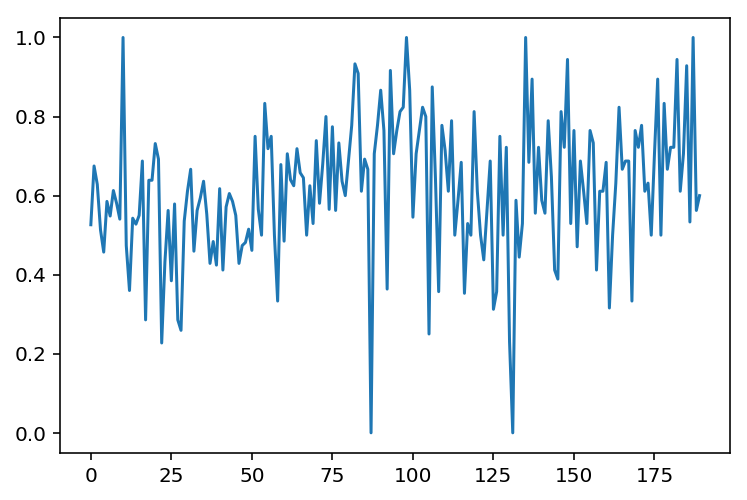

In [28]:
plt.plot(fed_acc_df.head(1).values.flatten())

In [29]:
def inner_transpose(df):
    return df.stack().swaplevel(i=-2, j=-1).unstack()

hyper_df = (
    config_df
    .rename_axis('config', axis=0)
    .reset_index()
    .groupby(['config'] + list(config_df.columns))
    # query the results dataframe from config_df_list
    # dropping the index so all the evaluated epochs line up 
    # TODO: maybe change this
    .apply(lambda df: results_df_list[df['config'].values[0]]['test_acc'].unstack())
    )

In [30]:
hyper_df.head(1)

,,,,,,,,,,,,,,,,gid,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
config,batch_size,data_dir,data_size,dataset,date,description,eval_every,latent_config,lr,model_size,num_epochs,print_freq,seed,testing,z_dim,epoch,,,,,,,,,,,,,,,,,,,,,
0,200,data,small,femnist,08-11 21-46-21,"actually using KL loss, properly weighted",1,double,0.004,small,10,10,1227,False,"[16, 16]",1,0.7368,0.825,0.6857,0.8108,0.6571,0.7561,0.5806,0.7097,0.6129,0.6486,...,0.7778,0.8889,1.0,0.9444,0.8824,1.0,0.6,1.0,0.75,0.8


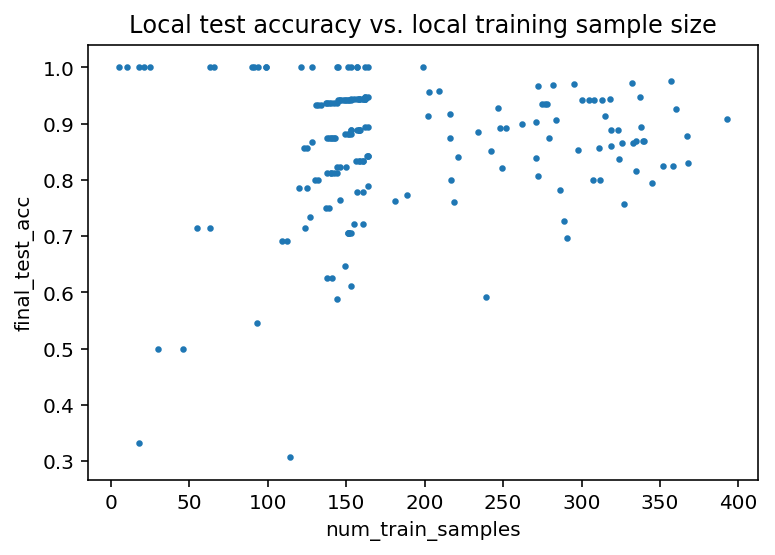

In [31]:
config_num = 9
pd.concat([hyper_df.loc[config_num].tail(1).reset_index(drop=True).T[0].rename('final_test_acc'), 
           samples_per_writer], axis=1).plot.scatter(x='num_train_samples', y='final_test_acc', s=5)
plt.title('Local test accuracy vs. local training sample size');

In [32]:
hyper_df.pipe(inner_transpose).groupby(level=8).mean()[10]

latent_config
bias       0.8038
double     0.8565
factor     0.8450
factor2    0.8465
lower      0.8509
weight     0.8409
Name: 10, dtype: float64

# Inspect model

### Read in model

In [33]:
config_num = 9
display(config_df.loc[config_num].to_frame().T.drop(['data_dir', 'eval_every', 'testing', 'print_freq', 'seed'],axis=1))
with open(os.path.join('../experiments/femnist', directories[config_num], 'model_weights.pickle'), 'rb') as f:
    model_weights=pickle.load(f)

,batch_size,data_size,dataset,date,description,latent_config,lr,model_size,num_epochs,z_dim
9,200,small,femnist,08-21 23-30-56,"normal adam, log prob, factored weights, factored biases, lr sched",weight,0.004,small,10,"[10, 16]"


In [34]:
[x.shape for x in model_weights]

[(3, 3, 1, 16),
 (16,),
 (3, 3, 16, 32),
 (32,),
 (1568, 256),
 (256,),
 (10, 15872),
 (16, 62),
 (190, 10),
 (190, 10),
 (190, 16),
 (190, 16)]

In [35]:
%load_ext autoreload
%autoreload 2

from models.cnn import DoubleLatentCNN, LatentWeightCNN
import argparse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
args

Namespace(batch_size=200, data_dir='data', data_size='small', dataset='femnist', description='normal adam, log prob, factored weights, factored biases, lr sched', eval_every=1, latent_config='blubl', lr=0.004, model_size='small', num_epochs=10, print_freq=10, seed=1227, testing=True, z_dim=[10, 16])

In [40]:
### TODO: fix issues with reading in log prob model ###

In [38]:
args = argparse.Namespace()
args_dict = vars(args)
args_dict.update(hyperparams[config_num])
args_dict['latent_config'] = 'blubl'

opt = tf.keras.optimizers.Adam(1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
latent3000 = LatentWeightCNN(
    opt, loss_fn, x_train.shape[0], [len(np.unique(gid_train))], 
    args, experiment_dir=None, logger=None)
latent3000(x_train[:2], gid_train[:2].astype(np.int32))
latent3000.set_weights(model_weights);

ValueError: You called `set_weights(weights)` on layer "latent_weight_cnn_1" with a  weight list of length 12, but the layer was expecting 14 weights. Provided weights: [array([[[[-0.220261  , -0.01451612,  0.33116314, ...

In [36]:
latent3000.summary()

Model: "latent_weight_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple            

In [37]:
[x.shape for x in model_weights]

[(3, 3, 1, 16),
 (16,),
 (3, 3, 16, 32),
 (32,),
 (1568, 256),
 (256,),
 (10, 15872),
 (16, 62),
 (190, 10),
 (190, 10),
 (190, 16),
 (190, 16)]

### PCA latent space

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_mu = pca.fit_transform(latent3000.z_mu.numpy())
pca = PCA(n_components=2)
pca_sigma = pca.fit_transform(latent3000.z_sigma.numpy())

In [39]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
pca_mu2 = pca.fit_transform(latent3000.z2_mu.numpy())
pca2 = PCA(n_components=2)
pca_sigma2 = pca.fit_transform(latent3000.z2_sigma.numpy())

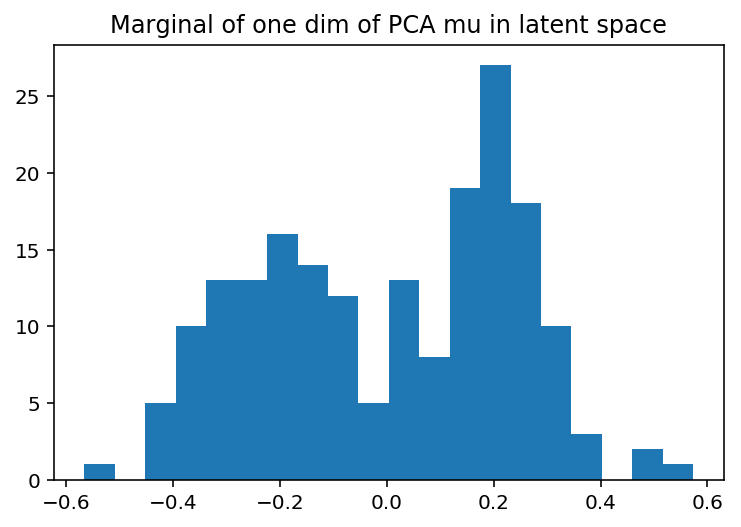

In [40]:
plt.hist(pca_mu[:,0], bins=20)
plt.title('Marginal of one dim of PCA mu in latent space');

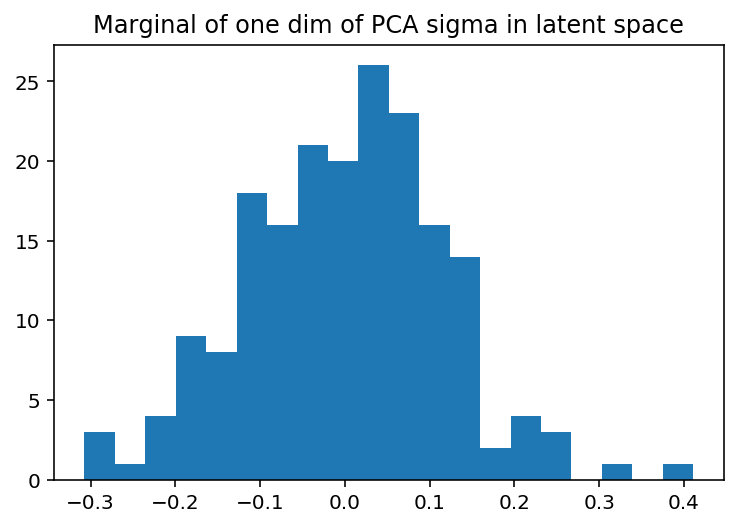

In [41]:
plt.hist(pca_sigma[:,0], bins=20)
plt.title('Marginal of one dim of PCA sigma in latent space');

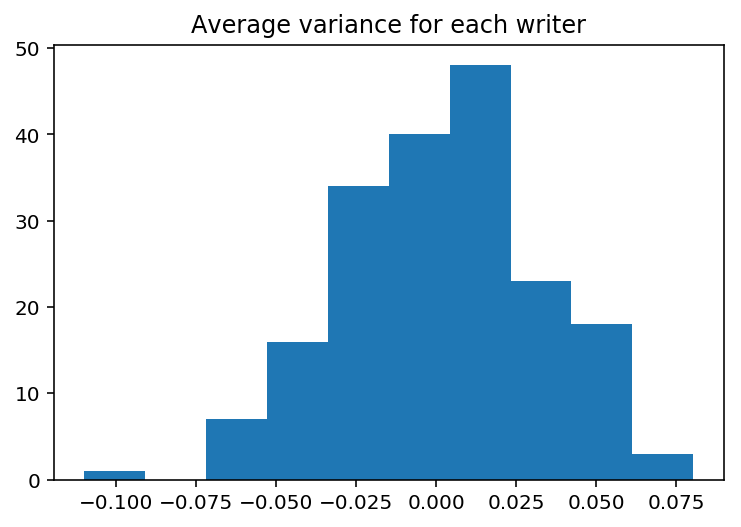

In [42]:
plt.hist(latent3000.z_sigma.numpy().mean(axis=1))
plt.title('Average variance for each writer');

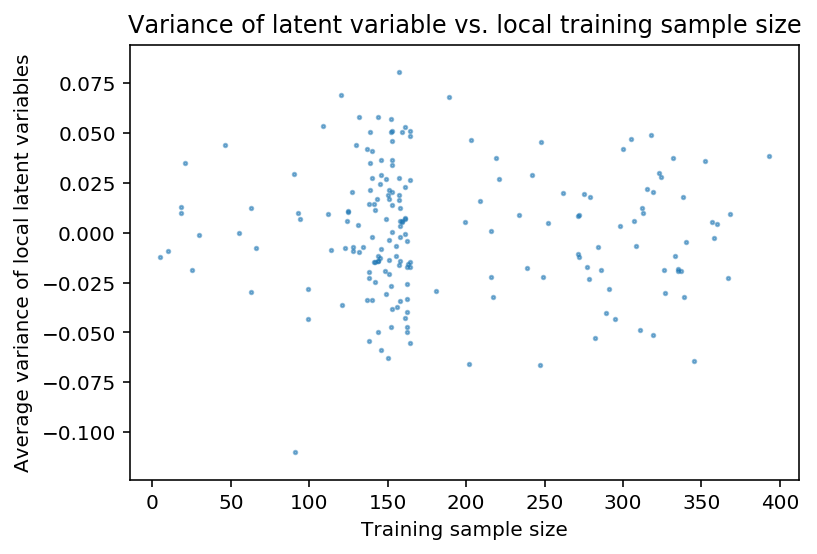

In [43]:
plt.scatter(samples_per_writer.values, 
            latent3000.z_sigma.numpy().mean(axis=1),
            s=3, alpha=0.5
            )
plt.xlabel('Training sample size')
plt.ylabel('Average variance of local latent variables')
plt.title('Variance of latent variable vs. local training sample size');

### Analyze Z1

In [44]:
from sklearn.mixture import GaussianMixture

mix = GaussianMixture(n_components=2, covariance_type='full')
mix.fit(latent3000.z_mu.numpy())

mix_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix.weights_),
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_identity_multiplier=mix.covariances_)
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_diag=mix.covariances_)
    components_distribution=tfd.MultivariateNormalFullCovariance(
loc=mix.means_, covariance_matrix=mix.covariances_));

W0821 03:03:41.903892 4430747072 deprecation.py:323] From /Users/milesturpin/miniconda3/envs/latent/lib/python3.5/site-packages/tensorflow_probability/python/internal/distribution_util.py:493: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


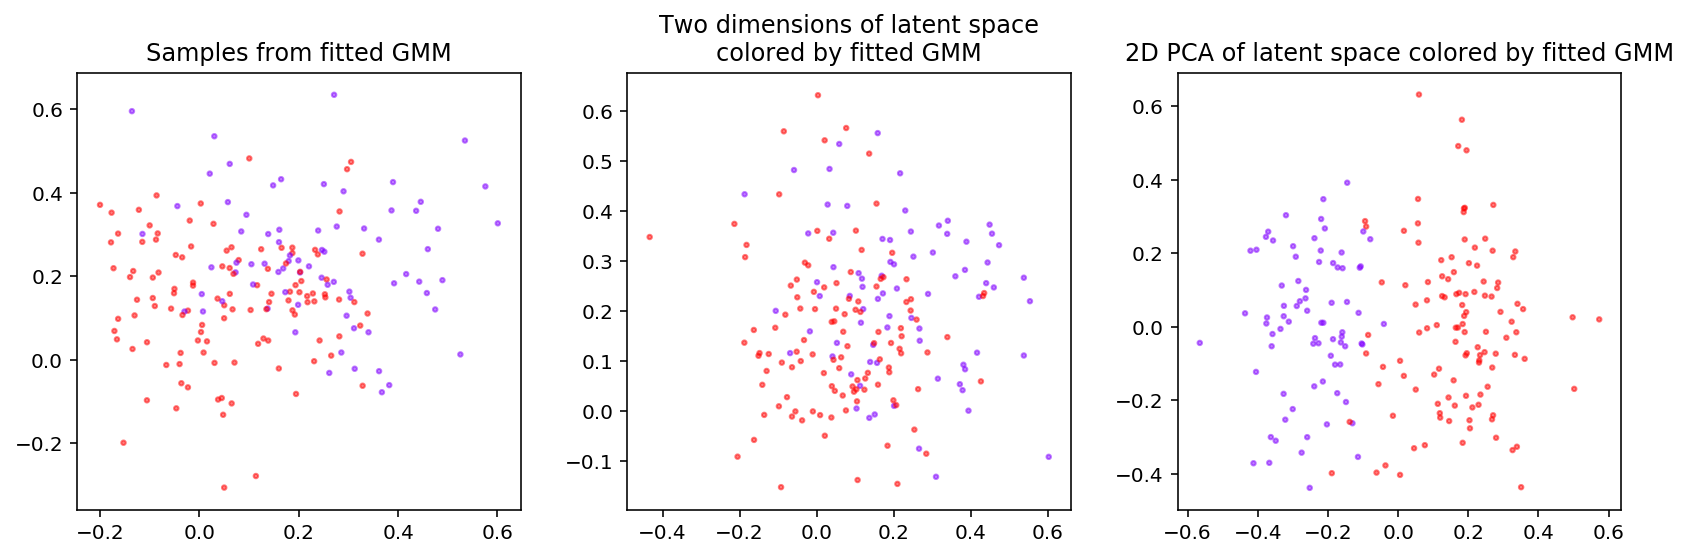

In [45]:
plt.figure(figsize=(12,4))
plt.subplot(131)

mix_samp = mix_dist.sample(190)
assign_samp = tfd.Categorical(probs=mix.predict_proba(mix_samp)).sample().numpy()

plt.scatter(mix_samp[:,1], mix_samp[:,2], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('Samples from fitted GMM')

plt.subplot(132)
z_space = latent3000.z_mu.numpy()
assign_samp = tfd.Categorical(probs=mix.predict_proba(z_space)).sample().numpy()
plt.scatter(z_space[:,1], z_space[:,2], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('Two dimensions of latent space\ncolored by fitted GMM')

plt.subplot(133)
z_space = pca_mu
plt.scatter(z_space[:,0], z_space[:,1], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('2D PCA of latent space colored by fitted GMM')
plt.tight_layout();

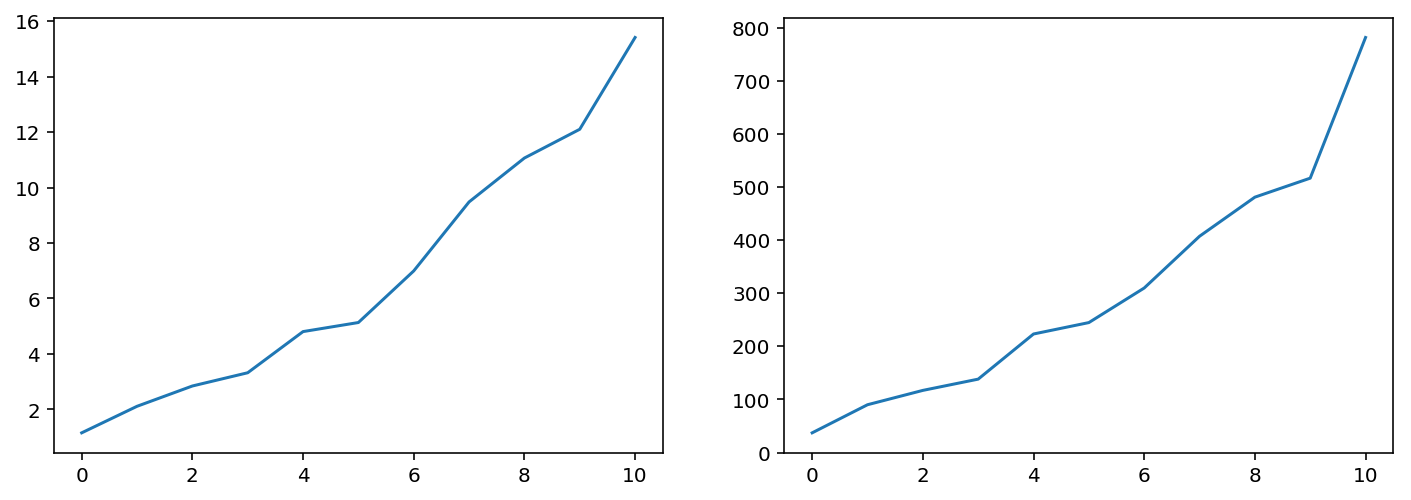

In [29]:
lst = []
aics=[]
bics=[]
logprobs =[ ]
from sklearn.model_selection import train_test_split
train, test = train_test_split(latent3000.z_mu.numpy())
for i in range(1,12):
    mix = GaussianMixture(n_components=i)
    mix.fit(latent3000.z_mu.numpy())
    
    
    mix_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix.weights_),
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_identity_multiplier=mix.covariances_)
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_diag=mix.covariances_)
    components_distribution=tfd.MultivariateNormalFullCovariance(
        loc=mix.means_, covariance_matrix=mix.covariances_))
    
    
    lst.append(mix.lower_bound_)
    aics.append(mix.aic(test))
    bics.append(mix.bic(test))
    logprobs.append(tf.reduce_sum(mix_dist.log_prob(test)))
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(lst)
plt.subplot(122)
plt.plot(logprobs);

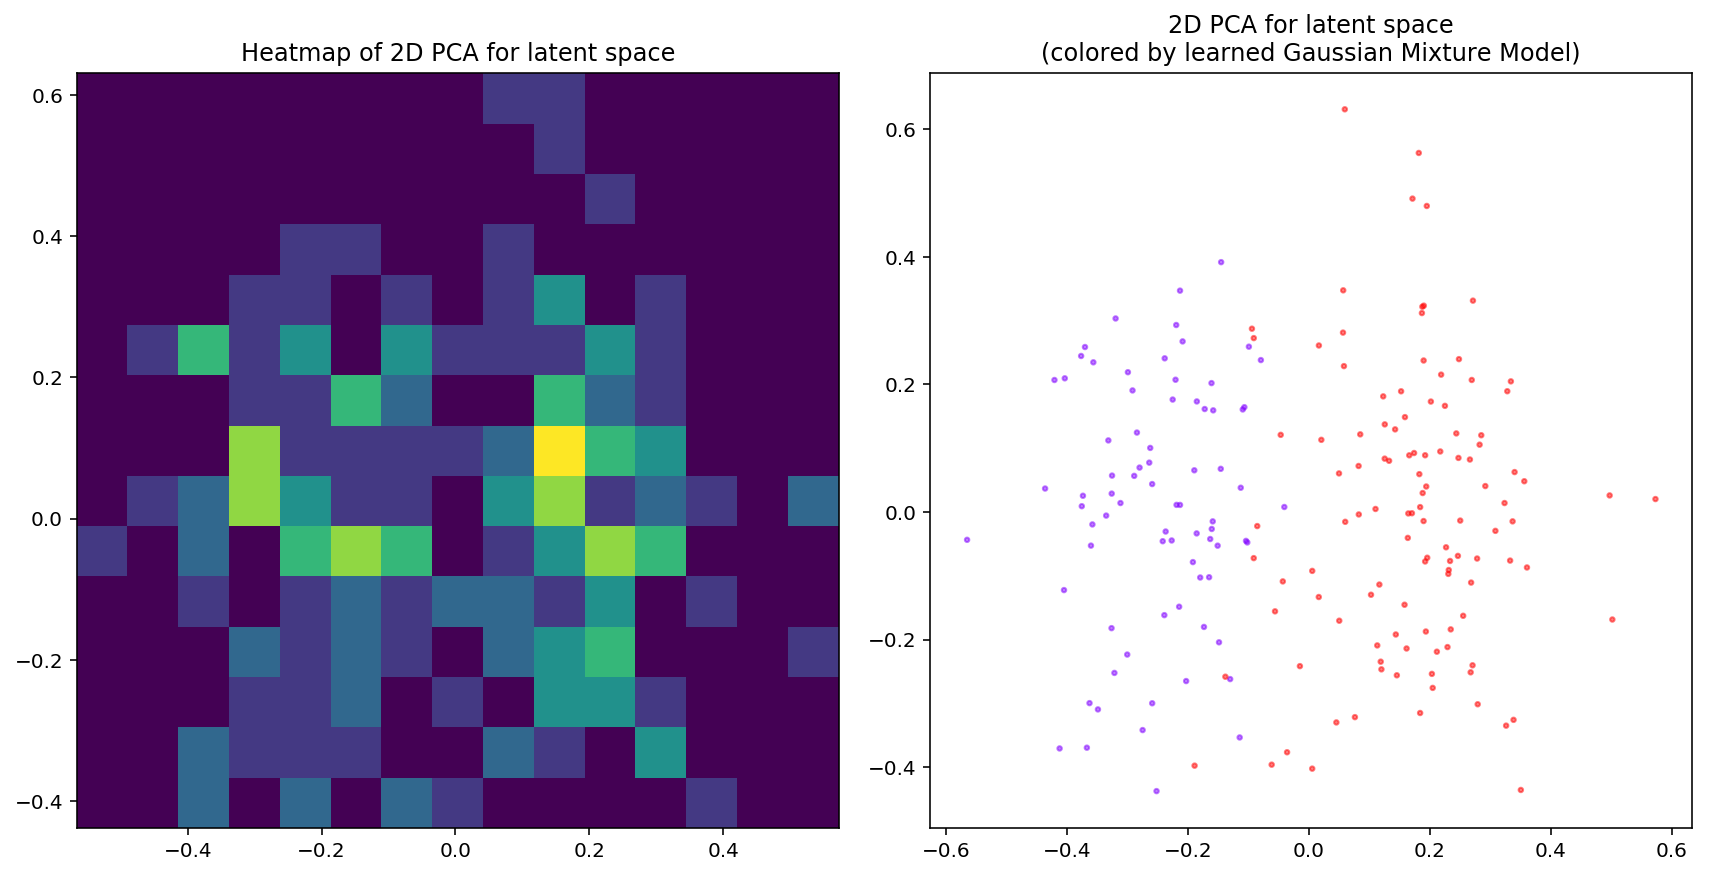

In [46]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.hist2d(pca_mu[:,0], pca_mu[:,1], bins=15)
plt.title('Heatmap of 2D PCA for latent space')

plt.subplot(122)
plt.scatter(pca_mu[:,0], pca_mu[:,1],
            c=assign_samp, 
            cmap='rainbow', s=5, alpha=0.5)

plt.scatter(pca_mu[:,0], pca_mu[:,1],
            c=assign_samp, 
            cmap='rainbow', 
            s=1000*np.square(np.mean(latent3000.z_sigma.numpy(),axis=1)), alpha=0.0001,)

plt.tight_layout()
plt.title('2D PCA for latent space\n(colored by learned Gaussian Mixture Model)');

### Factor loadings of Z1

In [32]:
mean_latent_vector = (
    pd.concat(
    [pd.DataFrame({'cluster':assign_samp}),
    pd.DataFrame(latent3000.z_mu.numpy())], 
    axis=1)
    .groupby('cluster')
    .mean())

In [33]:
mean_latent_vector

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cluster,,,,,,,,,,,,,,,,
0,-0.253945,-0.156605,0.025659,0.084378,-0.090637,0.073476,0.302103,0.810264,-0.457307,-0.290345,0.343214,0.543269,0.233996,0.587135,0.011140,0.666925
1,0.321390,0.155489,-0.024213,-0.076377,0.133467,-0.087793,-0.375013,-0.916667,0.531368,0.341435,-0.382686,-0.662440,-0.243281,-0.678724,0.010266,-0.786532


In [34]:
[x.shape for x in latent3000.get_weights()]

[(3, 3, 1, 16),
 (16,),
 (3, 3, 16, 32),
 (32,),
 (1584, 256),
 (256,),
 (272, 62),
 (62,),
 (190, 16),
 (190, 16),
 (190, 16),
 (190, 16)]

In [35]:
mean_latent_vector.shape

(2, 16)

In [374]:
#latent3000.get_weights()[-6][-16:].shape

In [376]:
latent3000.get_weights()[-2].shape

(190, 62)

In [47]:
latent3000.out.get_weights()[1].shape

(62,)

In [48]:
cluster_y_dist = tf.nn.softmax(
    (mean_latent_vector
    @ latent3000.get_weights()[-6][-16:]).values, 
    axis=1)

In [378]:
cluster_y_dist = tf.nn.softmax(
    (mean_latent_vector
    @ latent3000.get_weights()[-2]).values, 
    axis=1)

ValueError: Dot product shape mismatch, (2, 62) vs (190, 62)

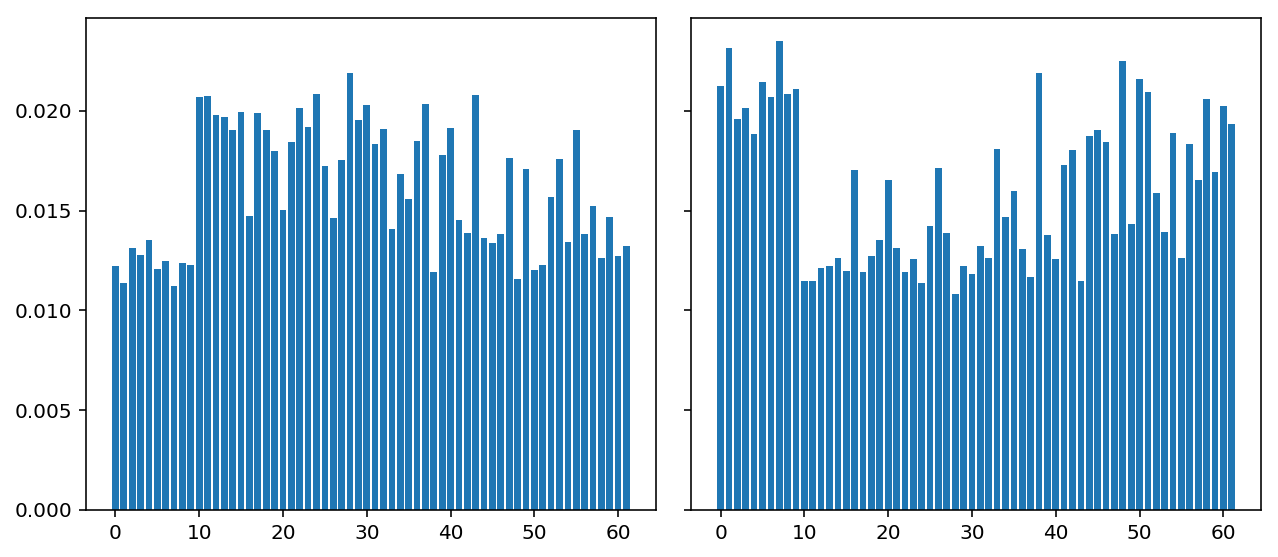

In [49]:
fig, axes = plt.subplots(1,2,figsize=(9,4), sharey=True)
for i in range(2):
    axes[i].bar(range(62),cluster_y_dist[i])
plt.tight_layout();

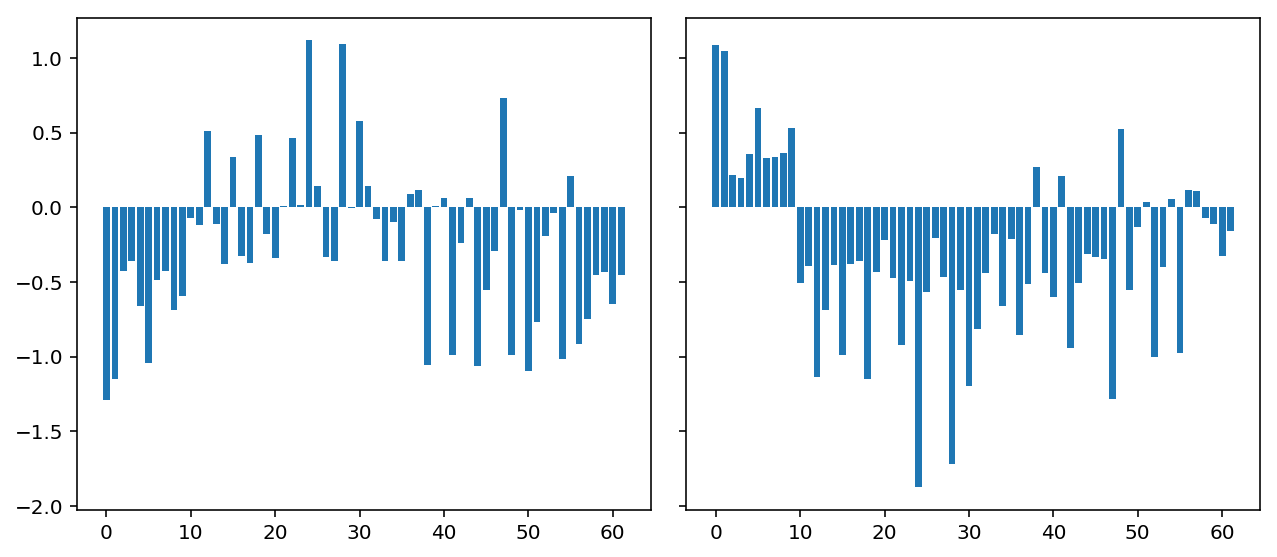

In [379]:
fig, axes = plt.subplots(1,2,figsize=(9,4), sharey=True)
for i in range(2):
    axes[i].bar(range(62),mean_latent_vector.loc[i].values)
plt.tight_layout();

#### Compare low rank bias matrix to full class distribution

In [88]:
factored_bias_matrix = (
    latent3000.z_mu.numpy() @ latent3000.get_weights()[-6][-16:])

In [153]:
from sklearn.preprocessing import StandardScaler

<Figure size 2160x432 with 0 Axes>

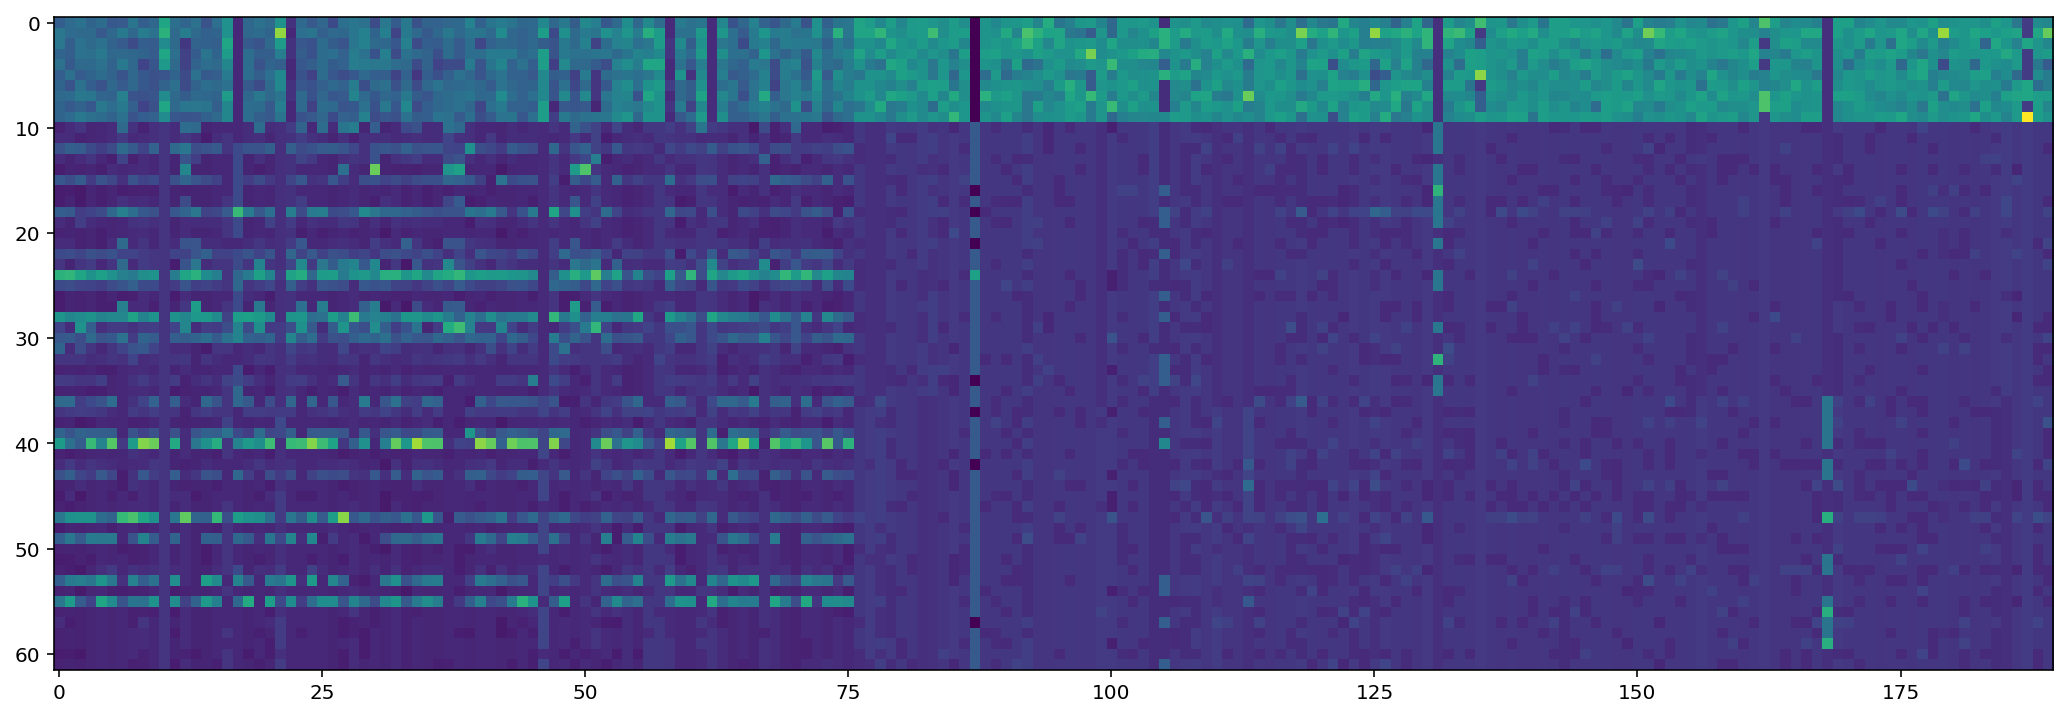

In [155]:
plt.figure(figsize=(30,6))
#plt.imshow((distribution_of_labels.values / distribution_of_labels.values.sum(axis=1, keepdims=True)).T)
norm_dist = (distribution_of_labels.values / distribution_of_labels.values.sum(axis=1, keepdims=True))
stand_dist = ((norm_dist - norm_dist.mean(axis=1, keepdims=True))/norm_dist.std(axis=1, keepdims=True))
plt.imshow(stand_dist.T)

In [120]:
pca = PCA(n_components=16)
class_pca = pca.fit_transform(distribution_of_labels.values)

In [164]:
u, s, vh = np.linalg.svd(stand_dist, full_matrices=False)

<Figure size 2160x432 with 0 Axes>

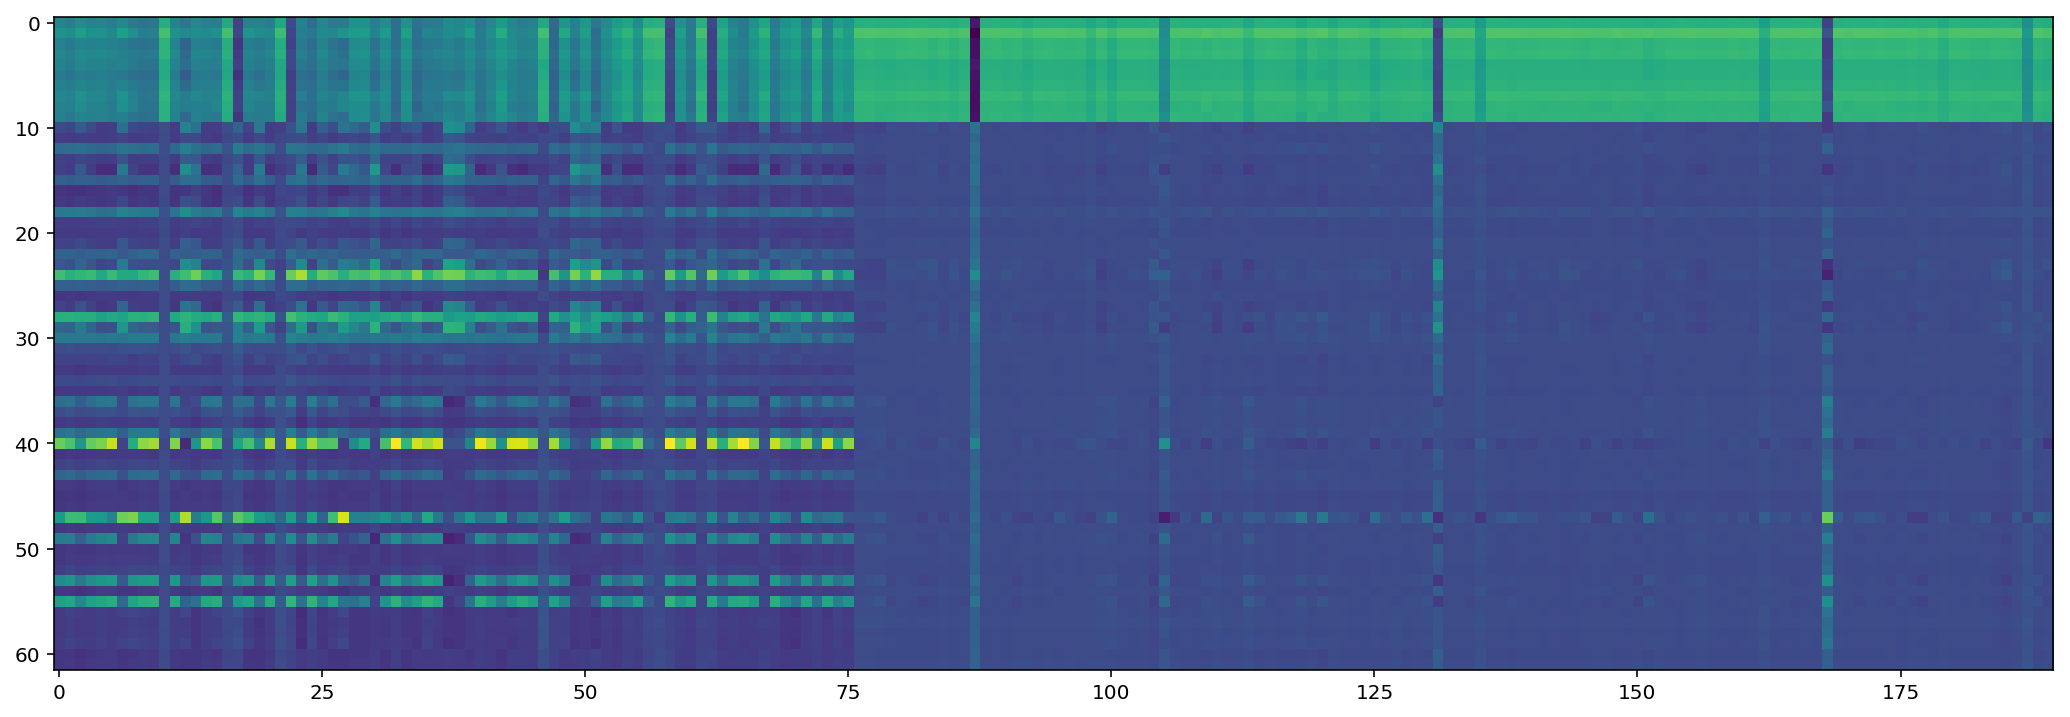

In [168]:
plt.figure(figsize=(30,6))
rank = 4
plt.imshow((u[:,:rank] @ np.diag(s)[:rank,:rank] @ vh[:rank]).T)

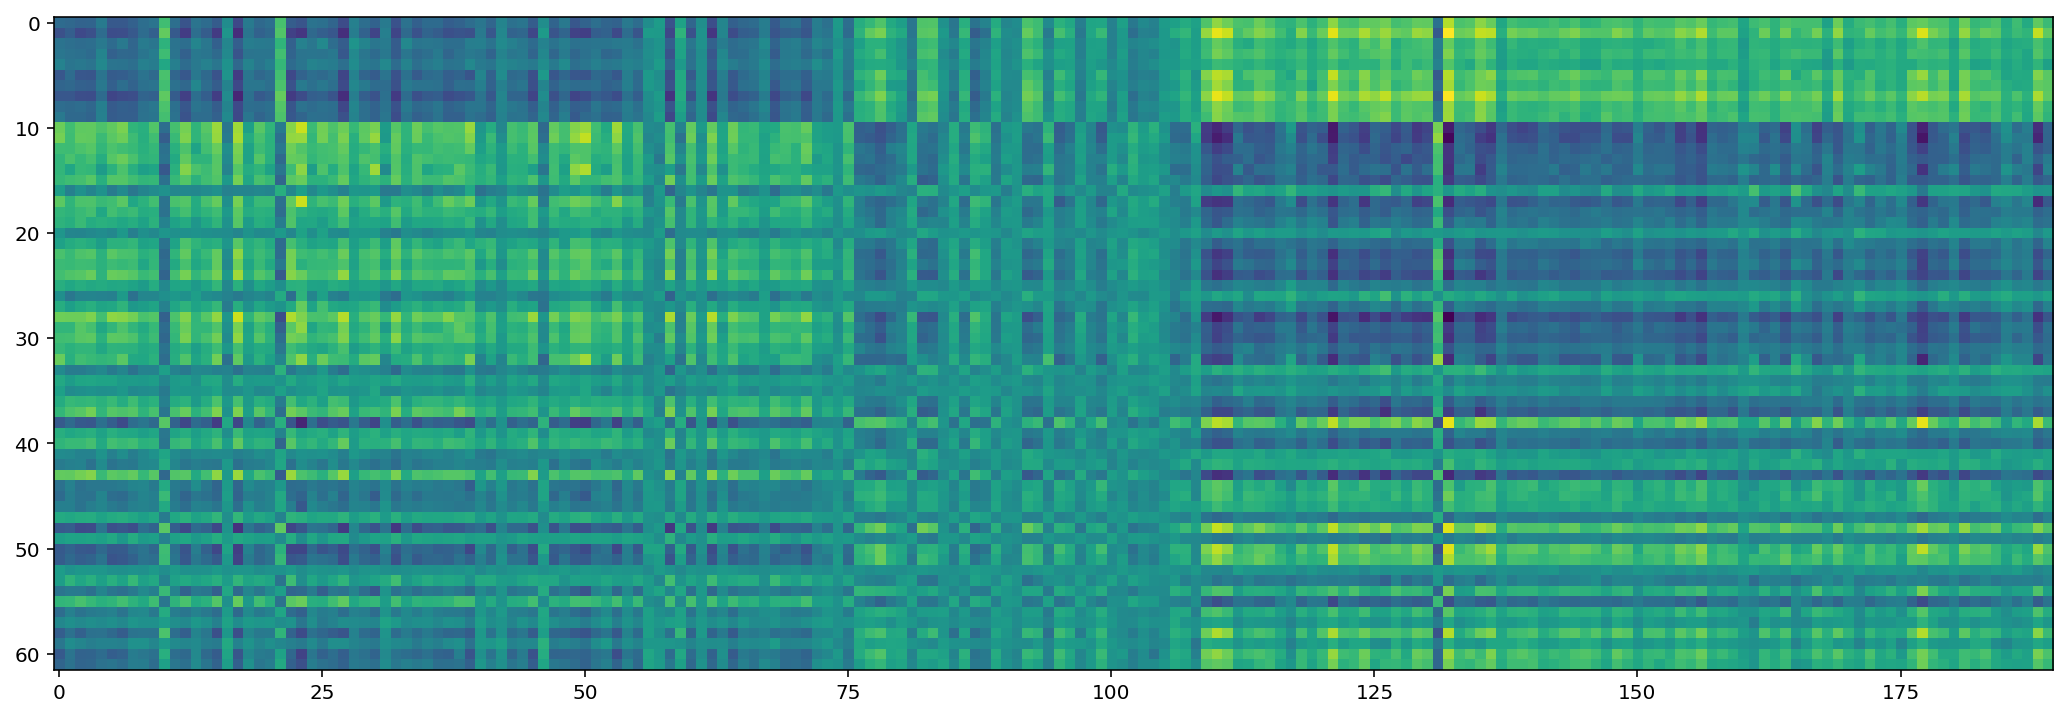

In [97]:
plt.figure(figsize=(30,6))
plt.imshow(factored_bias_matrix.T);

In [117]:
np.linalg.norm(distribution_of_labels.values, ord='fro')

575.2521186401664

In [116]:
np.linalg.norm(factored_bias_matrix, ord='fro')

26.693453

### Analyze Z2

In [47]:
from sklearn.mixture import GaussianMixture

mix2 = GaussianMixture(n_components=2, covariance_type='full')
mix2.fit(latent3000.z2_mu.numpy())

mix2_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix2.weights_),
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_identity_multiplier=mix.covariances_)
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_diag=mix.covariances_)
    components_distribution=tfd.MultivariateNormalFullCovariance(
loc=mix2.means_, covariance_matrix=mix2.covariances_));

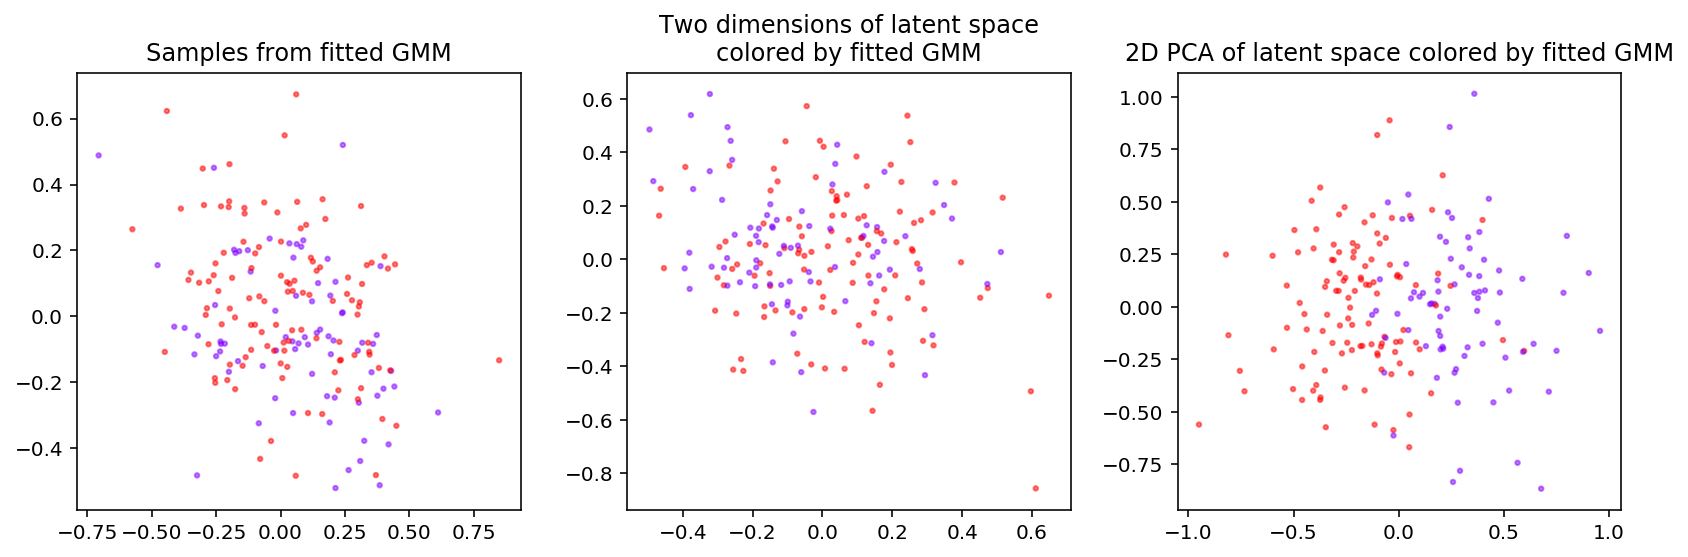

In [48]:
plt.figure(figsize=(12,4))
plt.subplot(131)

mix2_samp = mix2_dist.sample(190)
assign_samp = tfd.Categorical(probs=mix2.predict_proba(mix2_samp)).sample().numpy()
plt.scatter(mix2_samp[:,1], mix2_samp[:,0], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('Samples from fitted GMM')

plt.subplot(132)
z_space = latent3000.z2_mu.numpy()
assign_samp = tfd.Categorical(probs=mix2.predict_proba(z_space)).sample().numpy()
plt.scatter(z_space[:,0], z_space[:,1], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('Two dimensions of latent space\ncolored by fitted GMM')

plt.subplot(133)
z_space = pca_mu2
plt.scatter(z_space[:,0], z_space[:,1], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('2D PCA of latent space colored by fitted GMM')
plt.tight_layout();

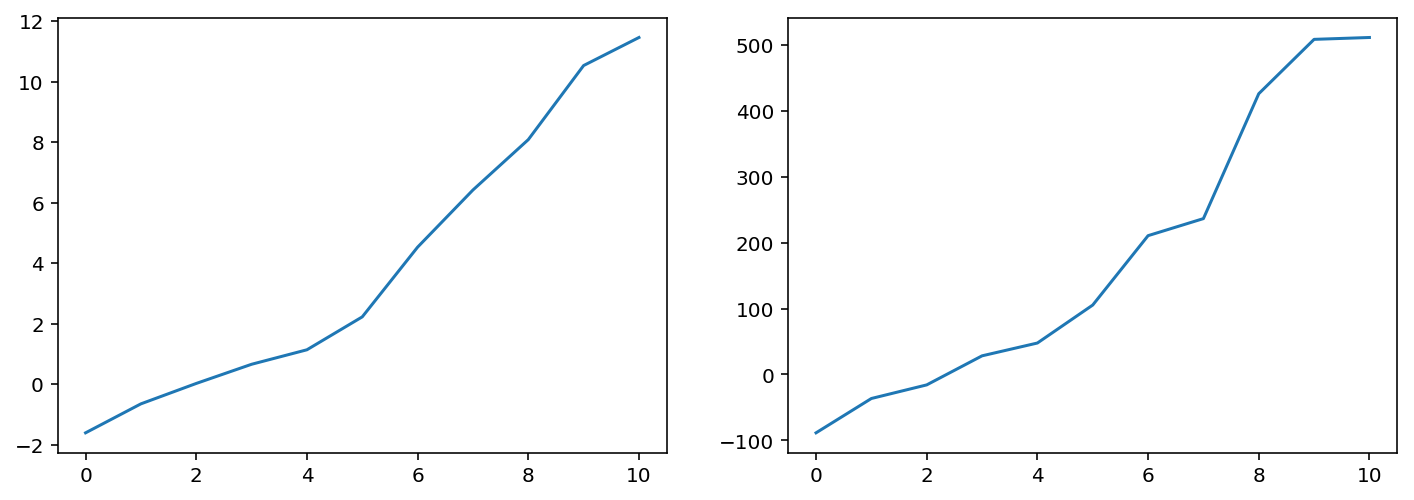

In [54]:
lst = []
aics=[]
bics=[]
logprobs =[ ]
from sklearn.model_selection import train_test_split
train, test = train_test_split(latent3000.z2_mu.numpy())
for i in range(1,12):
    mix2 = GaussianMixture(n_components=i)
    mix2.fit(latent3000.z2_mu.numpy())
    
    
    mix2_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix2.weights_),
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_identity_multiplier=mix.covariances_)
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_diag=mix.covariances_)
    components_distribution=tfd.MultivariateNormalFullCovariance(
        loc=mix2.means_, covariance_matrix=mix2.covariances_))
    
    
    lst.append(mix2.lower_bound_)
    aics.append(mix2.aic(test))
    bics.append(mix2.bic(test))
    logprobs.append(tf.reduce_sum(mix2_dist.log_prob(test)))
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(lst)
plt.subplot(122)
plt.plot(logprobs);

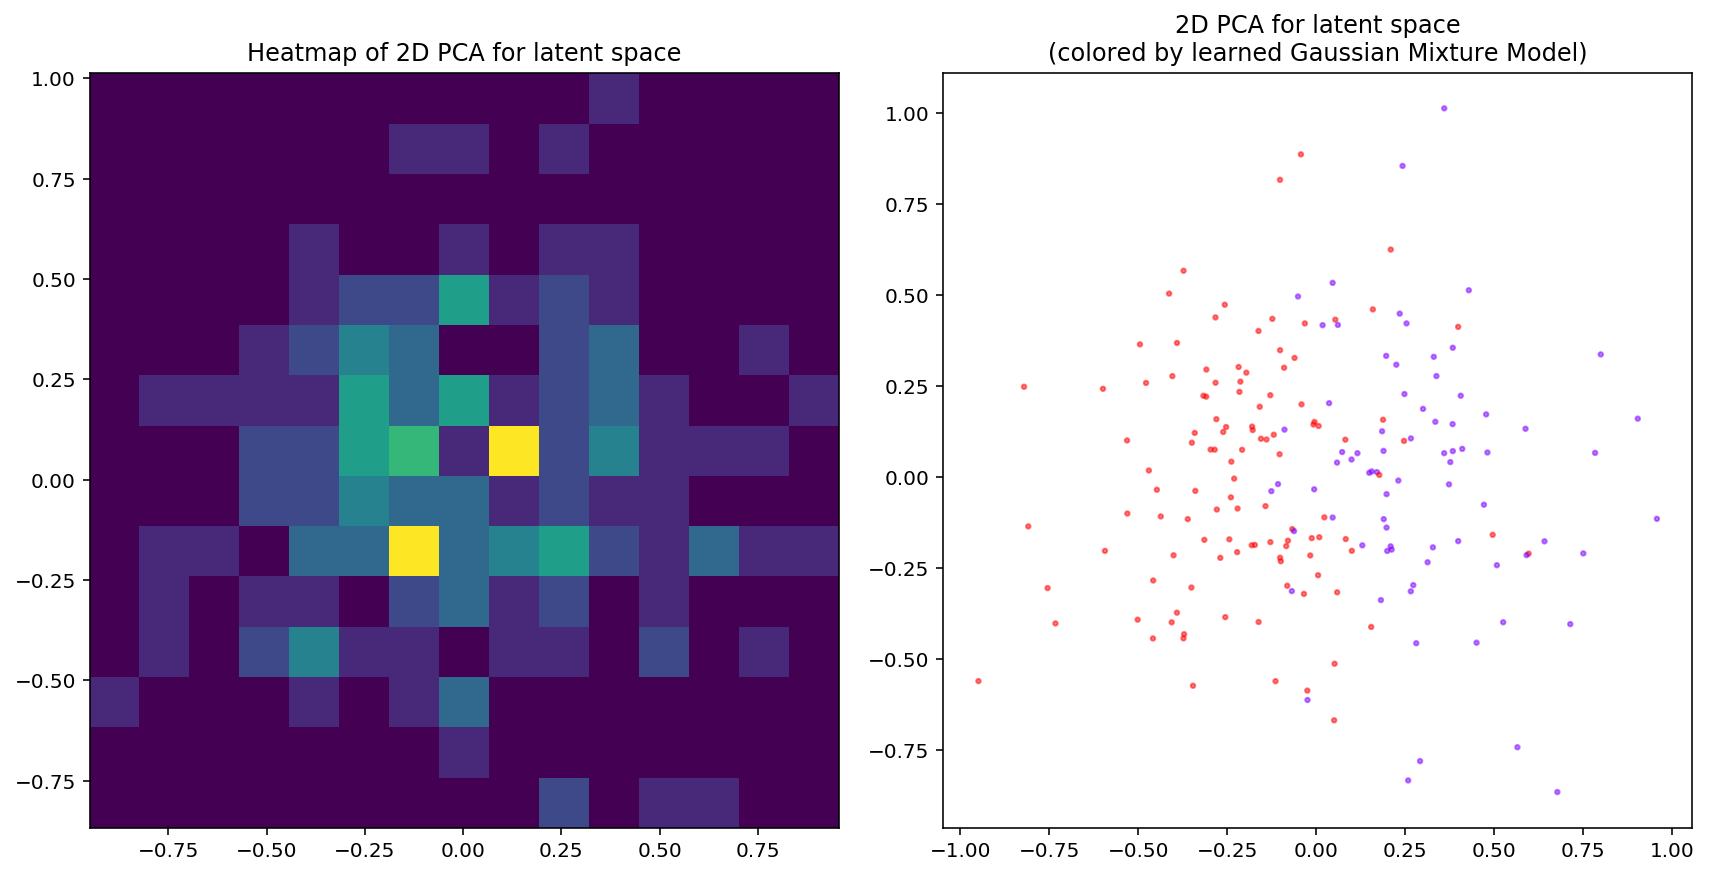

In [49]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.hist2d(pca_mu2[:,0], pca_mu2[:,1], bins=15)
plt.title('Heatmap of 2D PCA for latent space')

plt.subplot(122)
plt.scatter(pca_mu2[:,0], pca_mu2[:,1],
            c=assign_samp, 
            cmap='rainbow', s=5, alpha=0.5)

plt.scatter(pca_mu2[:,0], pca_mu2[:,1],
            c=assign_samp, 
            cmap='rainbow', 
            s=1000*np.square(np.mean(latent3000.z_sigma.numpy(),axis=1)), alpha=0.0001,)

plt.tight_layout()
plt.title('2D PCA for latent space\n(colored by learned Gaussian Mixture Model)');

### Factor loadings of Z2

In [56]:
mean_latent_vector = (
    pd.concat(
    [pd.DataFrame({'cluster':assign_samp}),
    pd.DataFrame(latent3000.z2_mu.numpy())], 
    axis=1)
    .groupby('cluster')
    .mean())

In [57]:
[x.shape for x in latent3000.get_weights()]

[(3, 3, 1, 16),
 (16,),
 (3, 3, 16, 32),
 (32,),
 (1584, 256),
 (256,),
 (272, 62),
 (62,),
 (190, 16),
 (190, 16),
 (190, 16),
 (190, 16)]

In [58]:
mean_latent_vector.shape

(2, 16)

In [59]:
latent3000.get_weights()[-8][-16:].shape

(16, 256)

In [60]:
cluster_y_dist = tf.nn.softmax(
    (mean_latent_vector
    @ latent3000.get_weights()[-8][-16:]).values, 
    axis=1)

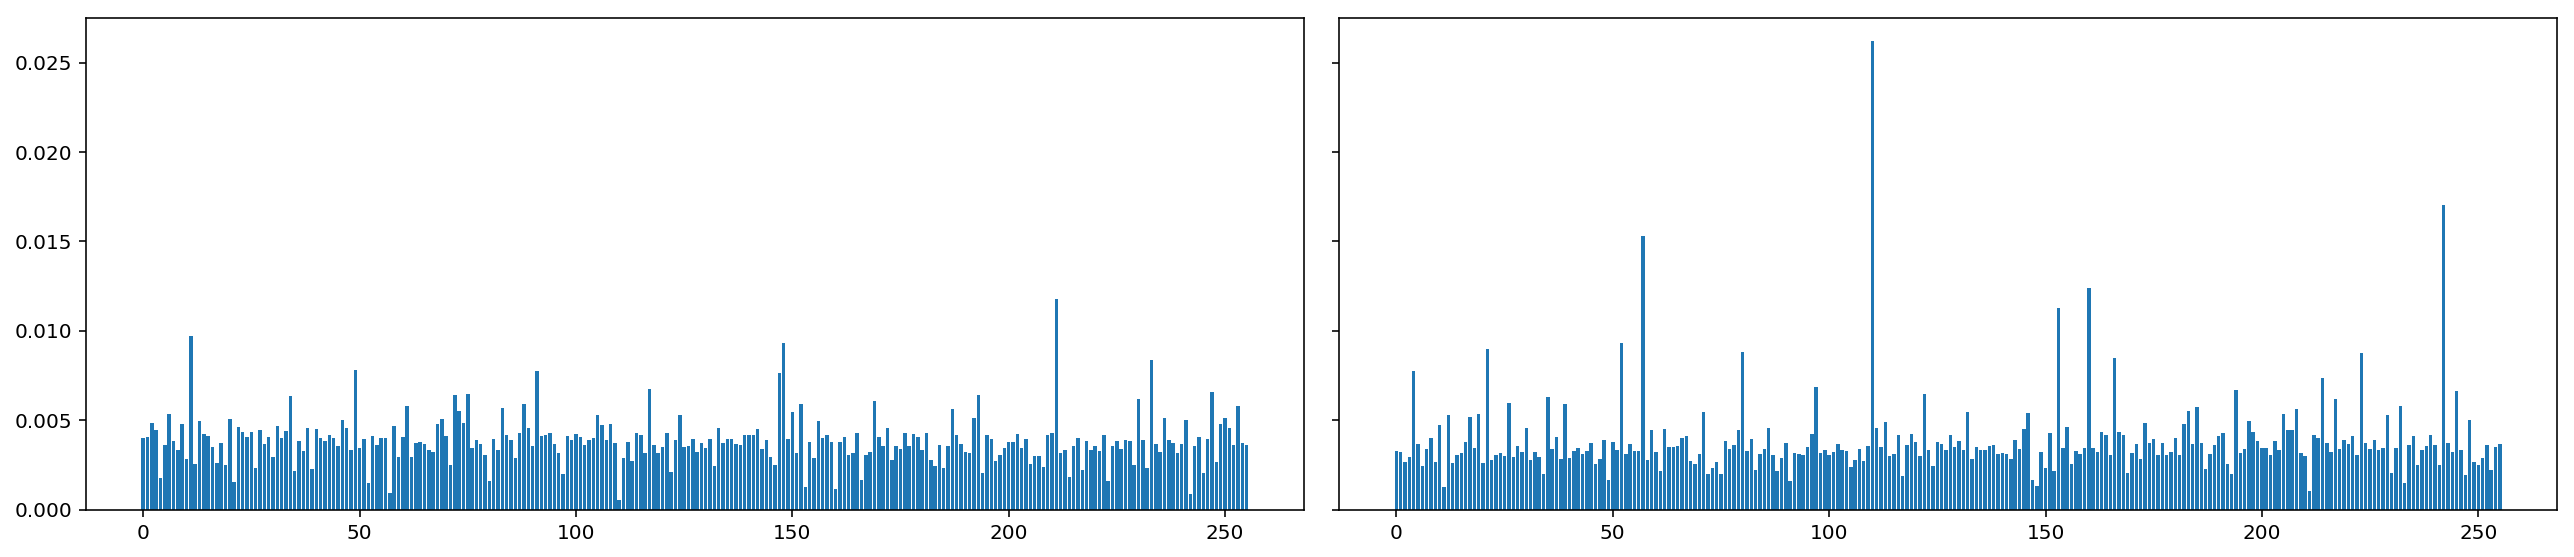

In [62]:
fig, axes = plt.subplots(1,2,figsize=(18,4), sharey=True)
for i in range(2):
    axes[i].bar(range(256),cluster_y_dist[i][:256])
plt.tight_layout();

### Look at letters and numbers across space

In [50]:
from functools import reduce


z_mu_df = pd.DataFrame(pca_mu)
numbers_count = sum(distribution_of_labels[i] for i in range(10)).rename('nums')
letters_count = sum(distribution_of_labels[i] for i in range(10, 62)).rename('lets')
lower_letters_count = sum(distribution_of_labels[i] for i in range(10, 36)).rename('lower_lets')
upper_letters_count = sum(distribution_of_labels[i] for i in range(36, 62)).rename('upper_lets')
df = pd.concat([numbers_count, letters_count, lower_letters_count, upper_letters_count, z_mu_df], 1)

num_bins = 15
df['dim1_bin'] = pd.cut(df[1], bins=num_bins).apply(lambda x: x.right)
df['dim2_bin'] = pd.cut(df[0], bins=num_bins).apply(lambda x: x.right)

In [51]:
df.head()

,nums,lets,lower_lets,upper_lets,0,1,dim1_bin,dim2_bin
0,107.0,231.0,122.0,109.0,-0.161117,0.201939,0.2040,-0.110
1,107.0,250.0,119.0,131.0,-0.405151,-0.122522,-0.0814,-0.338
2,105.0,207.0,118.0,89.0,-0.280144,0.069505,0.1320,-0.262
3,107.0,225.0,110.0,115.0,-0.335381,-0.005755,0.0611,-0.262
4,108.0,207.0,83.0,124.0,-0.299437,0.219012,0.2750,-0.262


In [52]:
df['cluster'] = assign_samp
df['number_prop'] = df['nums'] / (df['nums']+df['lets'])
df['letter_prop'] = df['lets'] / (df['nums']+df['lets'])
df['lower_let_prop'] = df['lower_lets'] / (df['lets'])
df['upper_let_prop'] = df['upper_lets'] / (df['lets'])
df.groupby('cluster')[['number_prop', 'letter_prop']].mean().round(3)

,number_prop,letter_prop
cluster,,
0,0.635,0.365
1,0.521,0.479


In [53]:
df.groupby('cluster')[[0,1]].mean()

,0,1
cluster,,
0,0.070113,0.007147
1,-0.047776,-0.004870


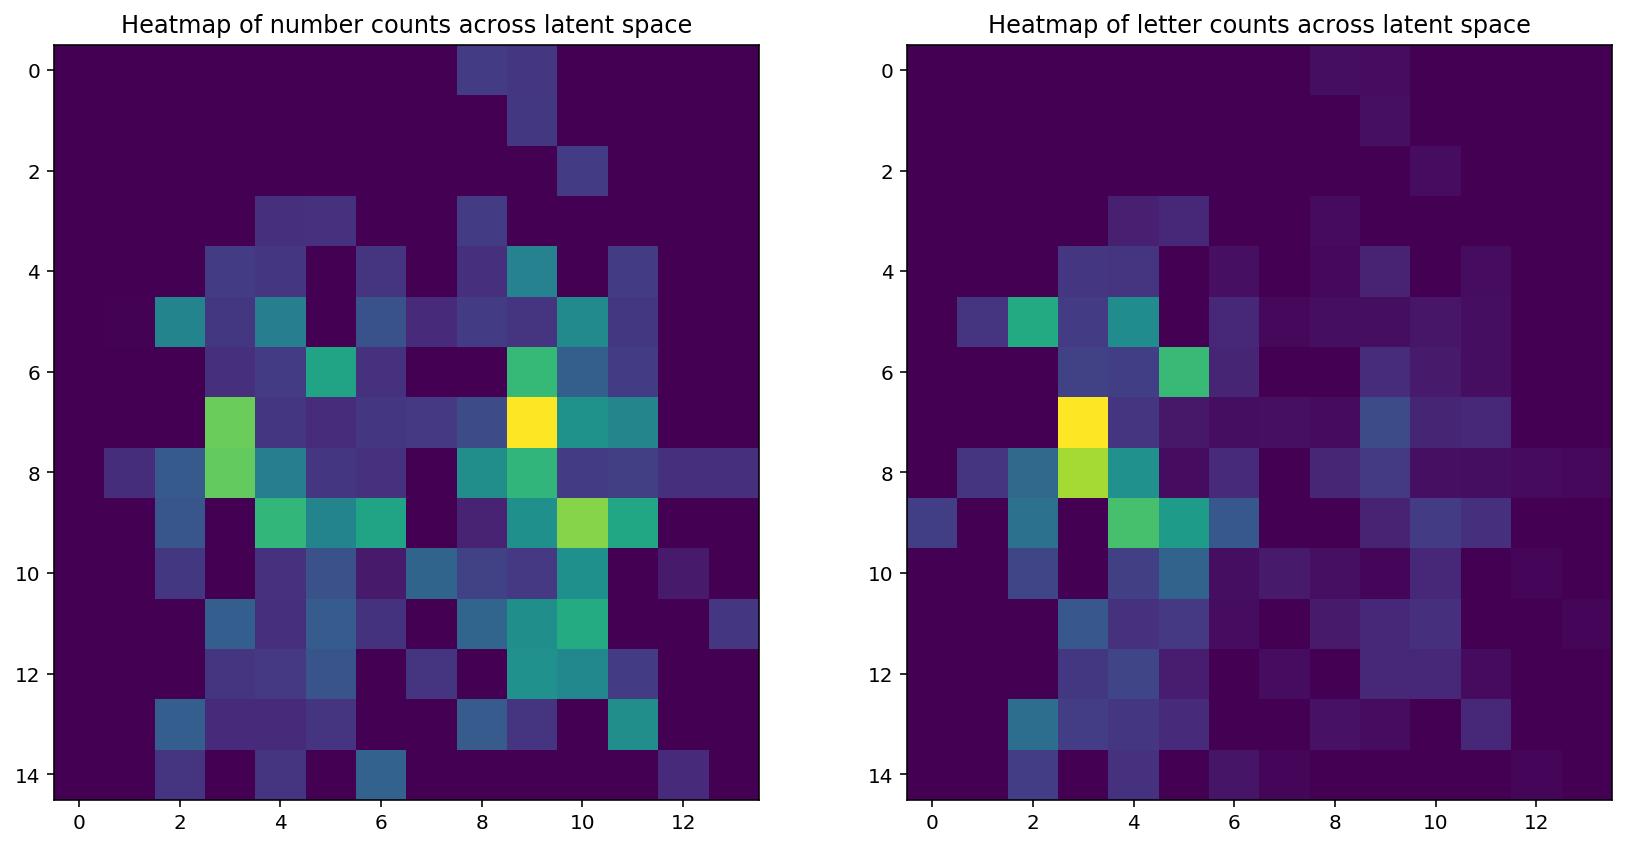

In [54]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.imshow(pd.pivot_table(
    df[['dim1_bin', 'dim2_bin', 'nums']],
    values='nums', index='dim1_bin', columns='dim2_bin', aggfunc='sum')
    .fillna(0).sort_index(axis=0,ascending=False))
plt.title('Heatmap of number counts across latent space')

plt.subplot(122)
plt.imshow(pd.pivot_table(
    df[['dim1_bin', 'dim2_bin', 'lets']],
    values='lets', index='dim1_bin', columns='dim2_bin', aggfunc='sum')
    .fillna(0).sort_index(axis=0,ascending=False))

plt.title('Heatmap of letter counts across latent space')
plt.tight_layout();

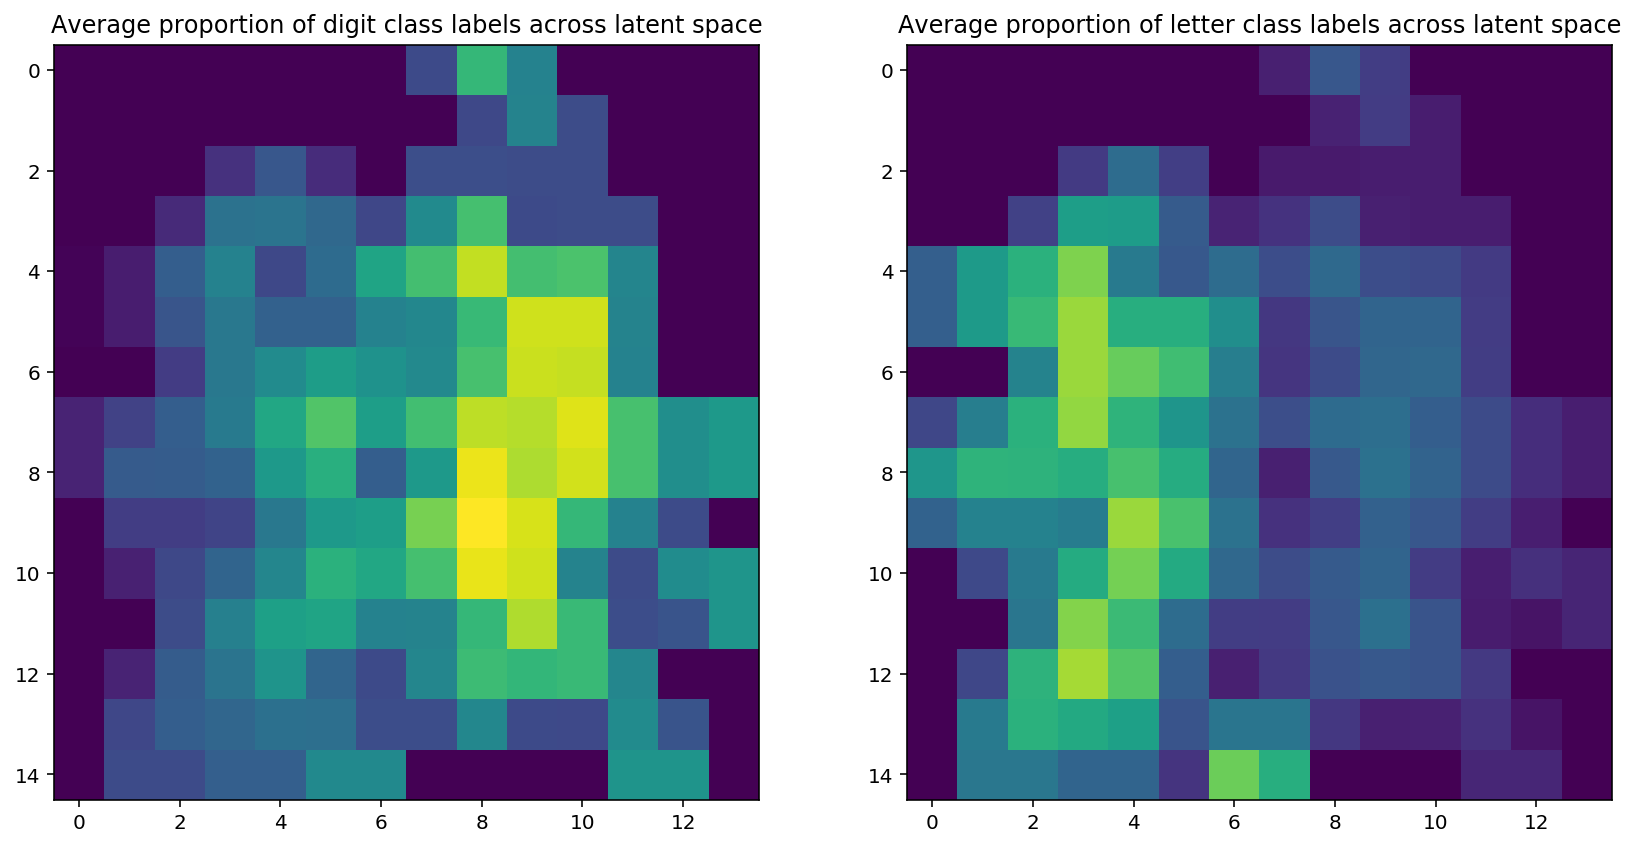

In [55]:
plt.figure(figsize=(12,6))

num_props = (
    pd.pivot_table(
        df[['dim1_bin', 'dim2_bin', 'number_prop']],
        values='number_prop', 
        index='dim1_bin', 
        columns='dim2_bin', 
        aggfunc='mean')
    .fillna(0)
    .sort_index(axis=0,ascending=False)
    .values)
num_props = np.expand_dims(np.expand_dims(num_props, axis=0), axis=-1)
num_props = tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')(num_props)

plt.subplot(121)
plt.imshow(np.squeeze(num_props), vmin=0, vmax=0.8)
plt.title('Average proportion of digit class labels across latent space')


let_props = (
    pd.pivot_table(
        df[['dim1_bin', 'dim2_bin', 'letter_prop']],
        values='letter_prop', 
        index='dim1_bin', 
        columns='dim2_bin', 
        aggfunc='mean')
    .fillna(0)
    .sort_index(axis=0,ascending=False)
    .values)
let_props = np.expand_dims(np.expand_dims(let_props, axis=0), axis=-1)
let_props = tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')(let_props)

plt.subplot(122)
plt.imshow(np.squeeze(let_props), vmin=0, vmax=0.8)
plt.title('Average proportion of letter class labels across latent space')

plt.tight_layout();

### Look at letters and numbers across z2 space

In [56]:
from functools import reduce


z_mu_df = pd.DataFrame(pca_mu2)
numbers_count = sum(distribution_of_labels[i] for i in range(10)).rename('nums')
letters_count = sum(distribution_of_labels[i] for i in range(10, 62)).rename('lets')
lower_letters_count = sum(distribution_of_labels[i] for i in range(10, 36)).rename('lower_lets')
upper_letters_count = sum(distribution_of_labels[i] for i in range(36, 62)).rename('upper_lets')
df = pd.concat([numbers_count, letters_count, lower_letters_count, upper_letters_count, z_mu_df], 1)

num_bins = 20
df['dim1_bin'] = pd.cut(df[1], bins=num_bins).apply(lambda x: x.right)
df['dim2_bin'] = pd.cut(df[0], bins=num_bins).apply(lambda x: x.right)

In [57]:
df.head()

,nums,lets,lower_lets,upper_lets,0,1,dim1_bin,dim2_bin
0,107.0,231.0,122.0,109.0,-0.297024,0.075456,0.168,-0.2820
1,107.0,250.0,119.0,131.0,-0.531750,0.100493,0.168,-0.4730
2,105.0,207.0,118.0,89.0,-0.208646,0.074849,0.168,-0.1870
3,107.0,225.0,110.0,115.0,-0.119647,0.116189,0.168,-0.0916
4,108.0,207.0,83.0,124.0,0.129120,-0.187984,-0.114,0.1940


In [58]:
df['cluster'] = assign_samp
df['number_prop'] = df['nums'] / (df['nums']+df['lets'])
df['letter_prop'] = df['lets'] / (df['nums']+df['lets'])
df['lower_let_prop'] = df['lower_lets'] / (df['lets'])
df['upper_let_prop'] = df['upper_lets'] / (df['lets'])
df.groupby('cluster')[['number_prop', 'letter_prop']].mean().round(3)

,number_prop,letter_prop
cluster,,
0,0.635,0.365
1,0.521,0.479


In [59]:
df.groupby('cluster')[[0,1]].mean()

,0,1
cluster,,
0,0.294913,-0.002297
1,-0.200958,0.001565


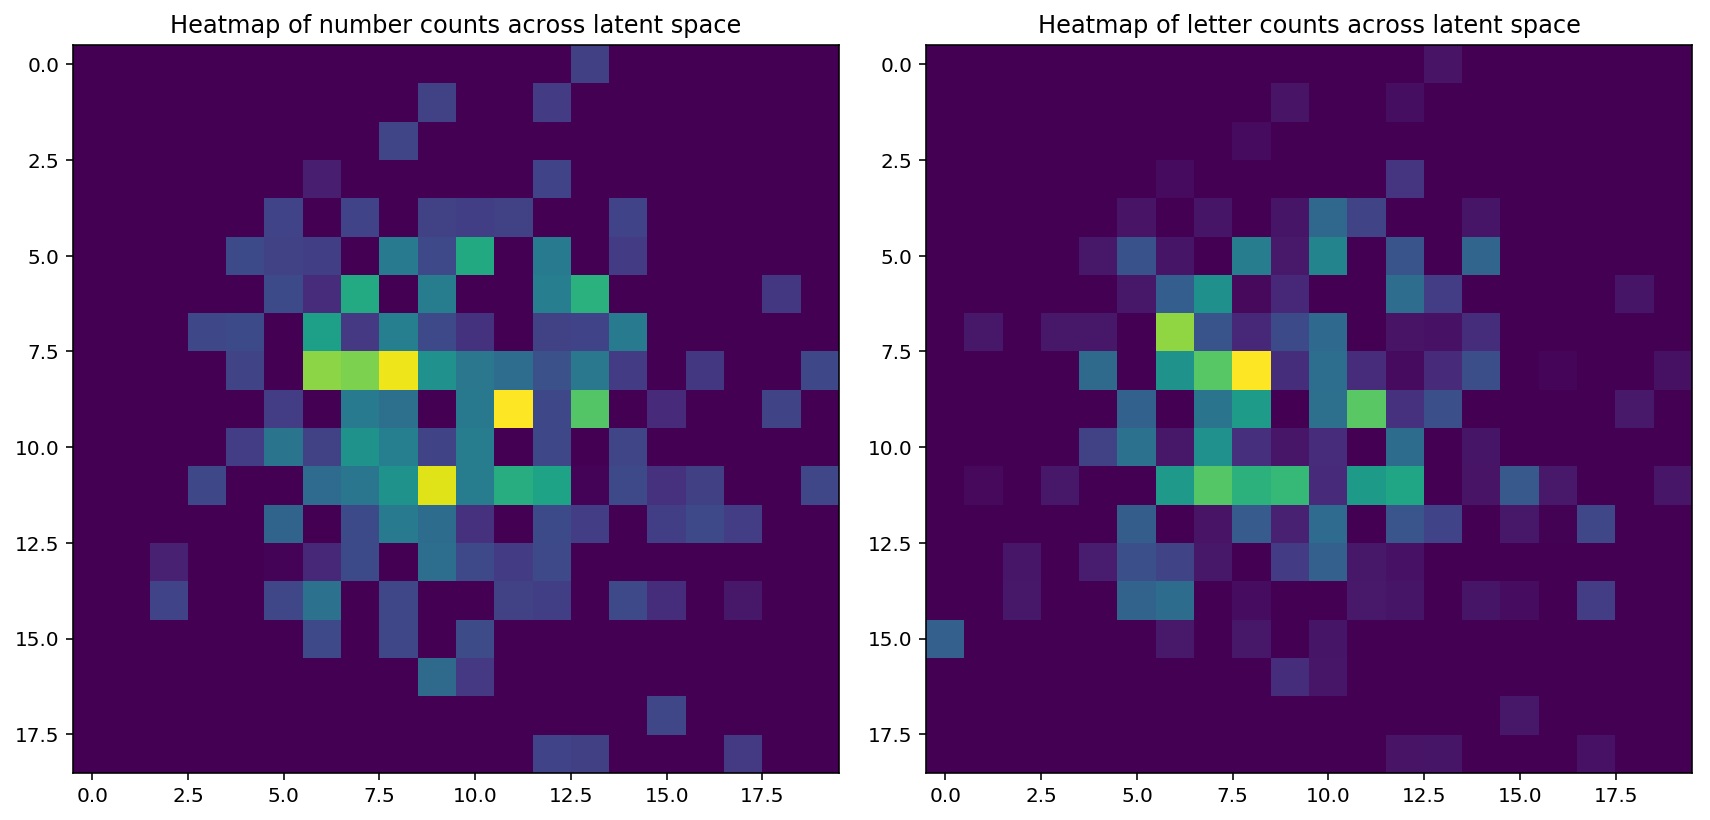

In [60]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.imshow(pd.pivot_table(
    df[['dim1_bin', 'dim2_bin', 'nums']],
    values='nums', index='dim1_bin', columns='dim2_bin', aggfunc='sum')
    .fillna(0).sort_index(axis=0,ascending=False))
plt.title('Heatmap of number counts across latent space')

plt.subplot(122)
plt.imshow(pd.pivot_table(
    df[['dim1_bin', 'dim2_bin', 'lets']],
    values='lets', index='dim1_bin', columns='dim2_bin', aggfunc='sum')
    .fillna(0).sort_index(axis=0,ascending=False))

plt.title('Heatmap of letter counts across latent space')
plt.tight_layout();

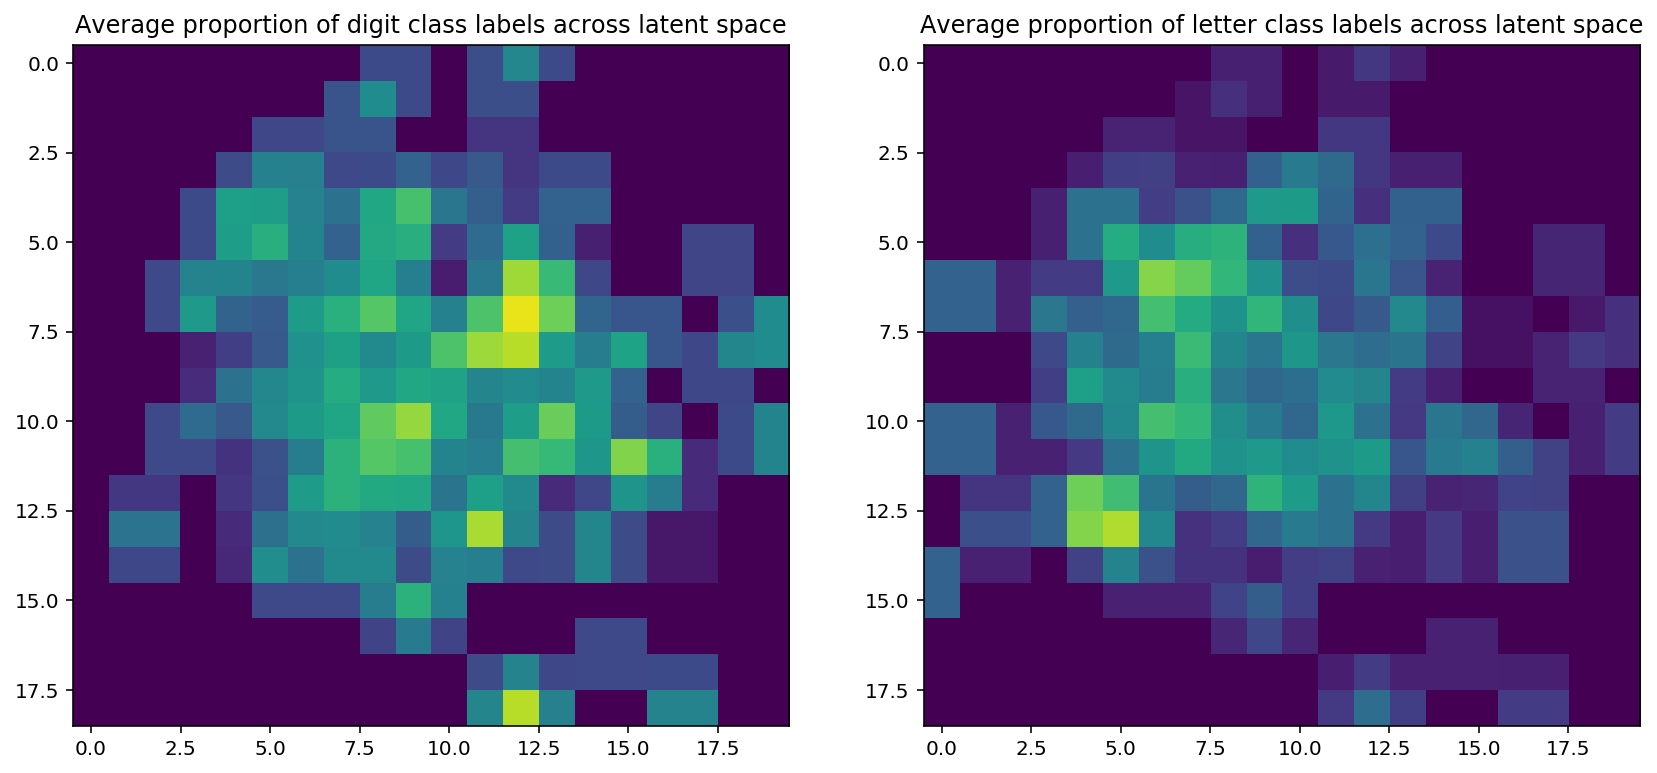

In [61]:
plt.figure(figsize=(12,6))

num_props = (
    pd.pivot_table(
        df[['dim1_bin', 'dim2_bin', 'number_prop']],
        values='number_prop', 
        index='dim1_bin', 
        columns='dim2_bin', 
        aggfunc='mean')
    .fillna(0)
    .sort_index(axis=0,ascending=False)
    .values)
num_props = np.expand_dims(np.expand_dims(num_props, axis=0), axis=-1)
num_props = tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')(num_props)

plt.subplot(121)
plt.imshow(np.squeeze(num_props), vmin=0, vmax=0.8)
plt.title('Average proportion of digit class labels across latent space')


let_props = (
    pd.pivot_table(
        df[['dim1_bin', 'dim2_bin', 'letter_prop']],
        values='letter_prop', 
        index='dim1_bin', 
        columns='dim2_bin', 
        aggfunc='mean')
    .fillna(0)
    .sort_index(axis=0,ascending=False)
    .values)
let_props = np.expand_dims(np.expand_dims(let_props, axis=0), axis=-1)
let_props = tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')(let_props)

plt.subplot(122)
plt.imshow(np.squeeze(let_props), vmin=0, vmax=0.8)
plt.title('Average proportion of letter class labels across latent space')

plt.tight_layout();

### Sample z

(array([ 35., 132., 228., 247., 186.,  89.,  47.,  26.,   5.,   5.]),
 array([0.03025758, 0.04955536, 0.06885314, 0.08815092, 0.10744869,
        0.12674648, 0.14604424, 0.16534202, 0.1846398 , 0.20393758,
        0.22323535], dtype=float32),
 <a list of 10 Patch objects>)

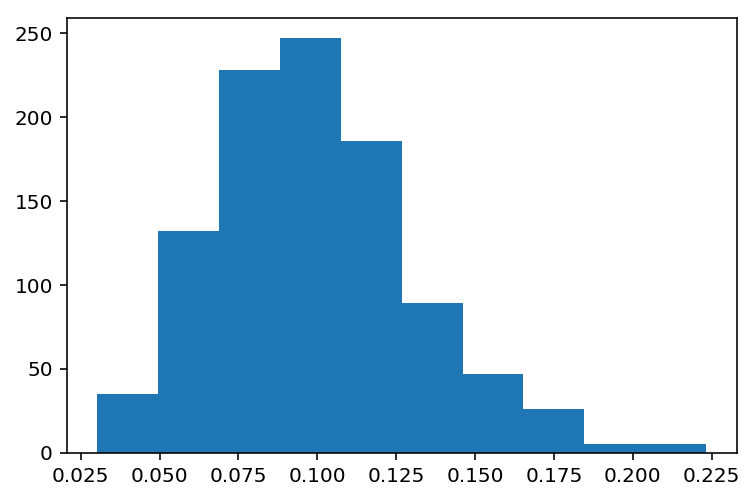

In [82]:
plt.hist(tfd.Gamma(10,100).sample(1000))

In [75]:
labels = list(string.digits +  string.ascii_uppercase + string.ascii_lowercase)
labels_dict = {i: labels[i] for i in range(62)}
num2label = lambda arr: list(map(lambda x: labels_dict[x], arr))

In [76]:
#potentially expensive
samp = latent3000.call_sample_z(x_test[:10000], gid_test[:10000], num_samples=20)

AttributeError: 'DoubleLatentCNN' object has no attribute 'call_sample_z'

In [742]:
# sampling all writers!
samp = latent3000.call_sample_z(np.tile(x_test[939], 3500).reshape((3500,784)), 
                                np.unique(gid_test), 
                                num_samples=20)

In [535]:
samp[0].shape

TensorShape([20, 3500, 62])

In [783]:
scores, log_importance_weights = samp
scores, log_importance_weights = scores.numpy(), log_importance_weights.numpy()
importance_weights = tf.exp(log_importance_weights)

In [784]:
scores.shape, log_importance_weights.shape

((20, 10000, 62), (20, 10000))

#### NOTE: change to drop in approx

In [787]:
numerator = (
    tf.reduce_sum(scores * tf.expand_dims(tf.exp(log_importance_weights), axis=2), axis=0))

imp_weight_sum = np.expand_dims(tf.reduce_sum(importance_weights, axis=0), axis=1)

#
#samp_imp = numerator / imp_weight_sum
samp_imp = tf.reduce_mean(scores, axis=0)

In [781]:
scores.shape

(20, 3500, 62)

In [713]:
np.percentile(log_importance_weights, 50, axis=0)

array([-8.15072823, -8.94680977, -9.31106949, ..., -5.42580223,
       -4.74206352, -4.83597183])

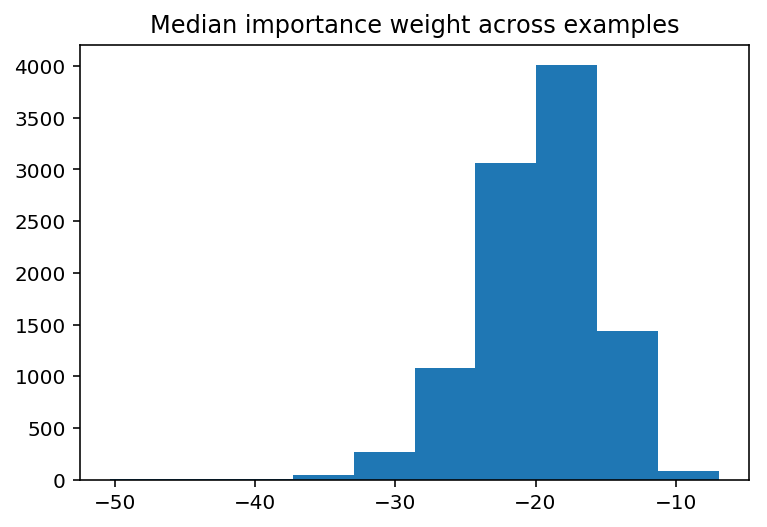

In [714]:
plt.hist(np.percentile(log_importance_weights, 10, axis=0))
plt.title('Median importance weight across examples');

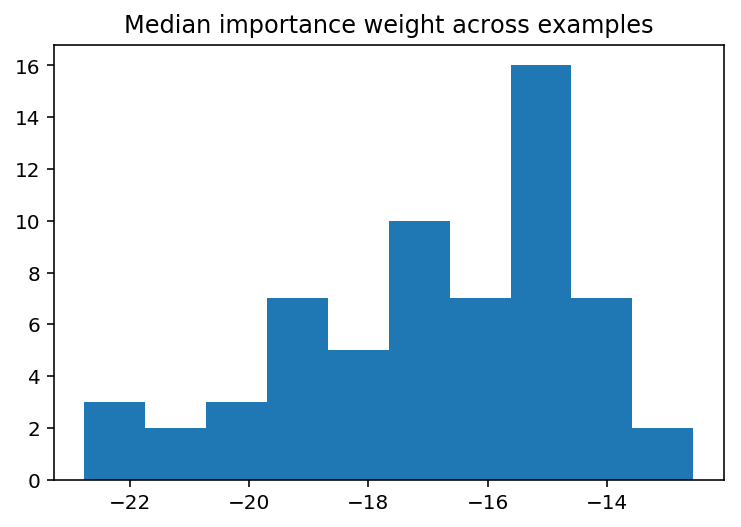

In [715]:
plt.hist(np.percentile(np.log(numerator), 50, axis=0))
plt.title('Median importance weight across examples');

<BarContainer object of 62 artists>

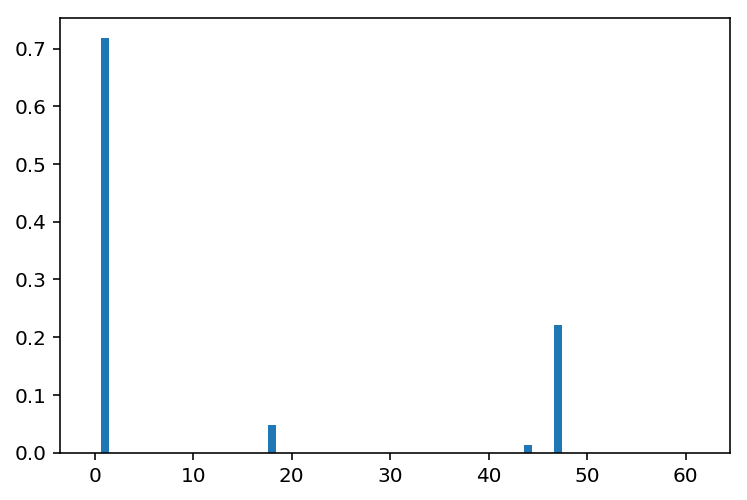

In [716]:
plt.bar(range(62), samp_imp[10])

In [ ]:
z_samp = latent3000.construct_mean_field_posterior(4).sample(20)

In [61]:
p_y_giv_xz = latent3000.call_sample_z(x_train[:100], gid_train[:100], num_samples=20)

In [63]:
x_train[:100].shape, gid_train[:100].shape

((100, 784), (100,))

In [32]:
samp[:,:100,:].shape

TensorShape([30, 100, 62])

In [268]:
def get_k_largest_elements(arr, k):
    return arr[np.argpartition]

In [93]:
softmax_out = tf.nn.softmax(tf.reduce_mean(samp[0], axis=0), axis=1).numpy()[:1000]

In [788]:
def sorted_argpartition():
    pass   

argpart = np.apply_along_axis(lambda row: np.argpartition(row, np.arange(-4,-1))[-4:][::-1], 1, 
                              samp_imp)
values = np.apply_along_axis(lambda row: np.sort(row)[-4:][::-1], 1, samp_imp)
softmax_df = pd.concat([
    pd.DataFrame(argpart).stack().rename('label_index'), 
    pd.DataFrame(values).stack().rename('softmax')], axis=1)

softmax_df['label_index'] = softmax_df[['label_index']].apply(num2label)
softmax_df = softmax_df.reset_index(level=1,drop=True).set_index('label_index', append=True)['softmax']
softmax_df = softmax_df.round(2)[softmax_df > 0.01]

In [789]:
(softmax_df.loc[np.random.choice(range(1000), size=10)]
 .groupby(level=0)
 .filter(lambda s: len(s) > 1)).head(20)

     label_index
201  3              0.96
     s              0.02
327  X              0.84
     x              0.16
413  k              0.61
     K              0.35
     X              0.02
     x              0.01
886  0              0.71
     O              0.25
     o              0.03
959  1              0.84
     l              0.12
     I              0.04
Name: softmax, dtype: float32

,predicted prob
label_index,
k,0.61
K,0.35
X,0.02
x,0.01


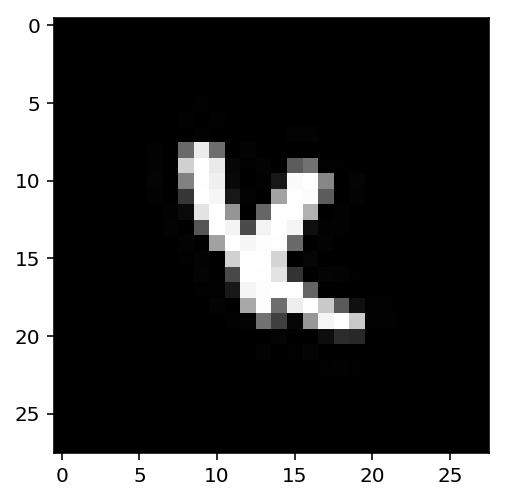

In [790]:
idx=413
display(softmax_df.loc[idx].rename('predicted prob').to_frame())
plt.imshow(
    x_test[idx].reshape((28,28)), 
    cmap='Greys');

In [748]:
softmax_df = softmax_df.to_frame()

softmax_df = (
    pd.merge(softmax_df.rename_axis(['id', 'label_index']), 
             pd.Series(assign_samp.astype(np.int64)).rename_axis('id').rename('cluster'), 
             left_index=True, right_index=True))

softmax_df['softmax'] = softmax_df['softmax'].astype(float)

In [749]:
softmax_df.groupby('cluster').apply(lambda df: df['softmax'].unstack()).groupby(level=0).mean().round(3)

,C,c,e
cluster,,,
0,0.586,0.251,0.162
1,0.804,0.064,0.131
2,0.705,0.141,0.153


softmax  cluster
gid  label                  
0    C         0.81        1
     e         0.13        1
     c         0.06        1
10   C         0.81        1
     e         0.12        1
     c         0.06        1
2551 C         0.60        0
     c         0.24        0
     e         0.16        0

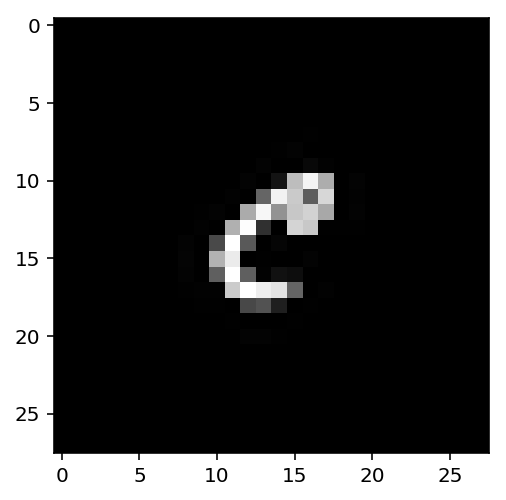

In [755]:
idx=[0,10,2551]
display(softmax_df.loc[idx].rename_axis(['gid','label'], axis='index'))
plt.imshow(
    x_test[939].reshape((28,28)), 
    cmap='Greys');

In [768]:
label_df = softmax_df.unstack().fillna(0)

merge_df = pd.concat([label_df['softmax'], z_mu_df], axis=1)

In [773]:
merge_df['dim1_bin'] = pd.cut(df[1], bins=30).apply(lambda x: x.right)
merge_df['dim2_bin'] = pd.cut(df[0], bins=30).apply(lambda x: x.right)

In [774]:
merge_df.head()

,C,e,c,0,1,dim1_bin,dim2_bin
0,0.81,0.13,0.06,-2.535095,0.117625,0.1290,-2.532
1,0.83,0.12,0.05,-2.522457,0.072561,0.0801,-2.274
2,0.83,0.13,0.04,-2.988214,0.127521,0.1290,-2.791
3,0.83,0.12,0.05,-2.957801,-0.174836,-0.1640,-2.791
4,0.78,0.13,0.09,-1.540960,-0.022707,-0.0176,-1.498


In [761]:
pd.pivot_table(
    merge_df[['dim1_bin', 'dim2_bin', 'l']],
    values='l', index='dim1_bin', columns='dim2_bin', aggfunc='mean')

KeyError: "['l'] not in index"

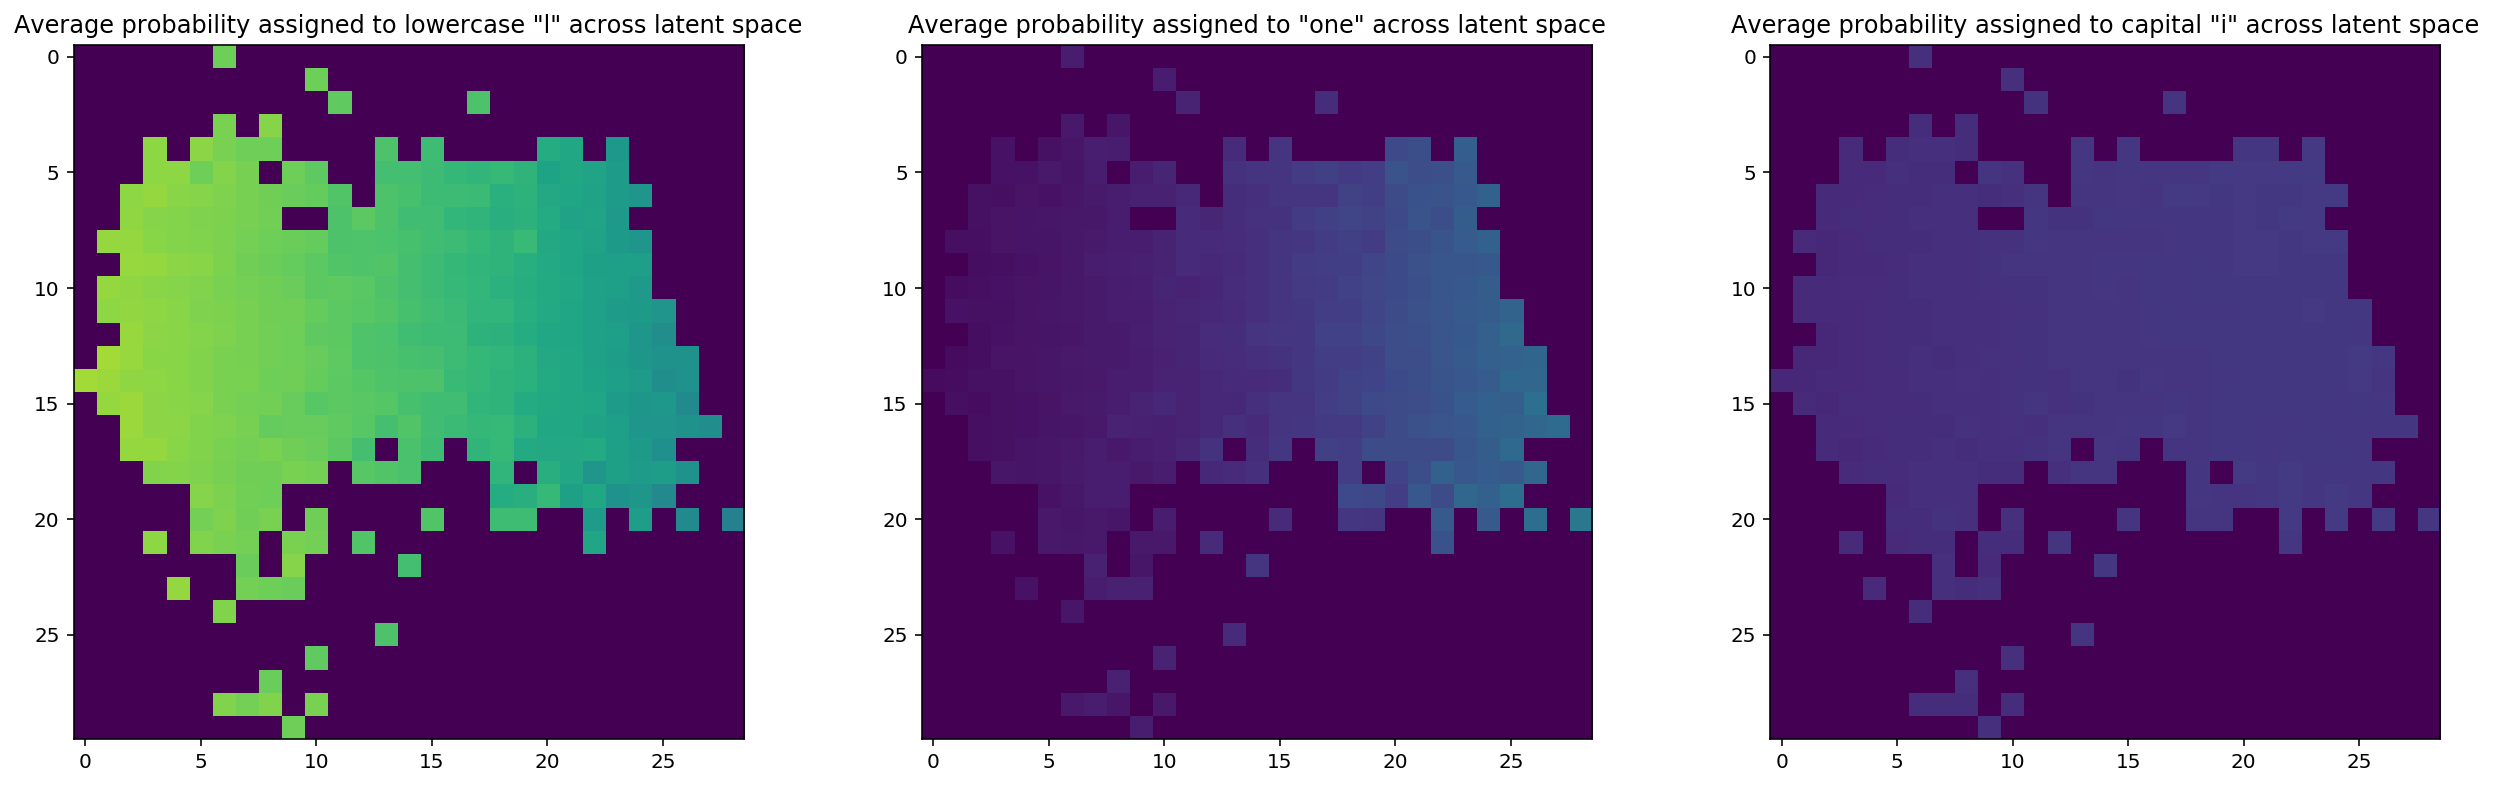

In [775]:
plt.figure(figsize=(18,6))

plt.subplot(131)
plt.imshow(pd.pivot_table(
    merge_df[['dim1_bin', 'dim2_bin', 'C']],
    values='C', index='dim1_bin', columns='dim2_bin', aggfunc='mean')
    .fillna(0), vmin=0, vmax=1)
plt.title('Average probability assigned to lowercase "l" across latent space')

plt.subplot(132)
plt.imshow(pd.pivot_table(
    merge_df[['dim1_bin', 'dim2_bin', 'c']],
    values='c', index='dim1_bin', columns='dim2_bin', aggfunc='mean')
    .fillna(0), vmin=0, vmax=1)

plt.title('Average probability assigned to "one" across latent space')

plt.subplot(133)
#tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')
plt.imshow(pd.pivot_table(
    merge_df[['dim1_bin', 'dim2_bin', 'e']],
    values='e', index='dim1_bin', columns='dim2_bin', aggfunc='mean')
    .fillna(0), vmin=0, vmax=1)

plt.title('Average probability assigned to capital "i" across latent space')
plt.tight_layout();